In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_context('paper', font_scale=1.5)
sns.set_style("whitegrid")

In [3]:
mpl.rcParams['figure.figsize'] = [10, 7]
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 17

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.3

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.family'] = 'DeJavu Serif'
mpl.rcParams['text.usetex'] = True

In [4]:
BPATH = "/home/dan/edu/uni/diplomka/tex/Images/charted/"

# Global plot func

In [5]:
import os

def savef(name):
    plt.tight_layout()
    plt.savefig(os.path.join(BPATH, name))

In [6]:
def plot_s1(x, y, title, xlabel, ylabel, *args, **kwargs):
    plt.figure()
    plt.plot(x, y, *args, **kwargs)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Trajectory

In [7]:
N = 250
SEED = 123

In [8]:
from kfsims.trajectory import trajectory
trj = trajectory(SEED, N)
true_traj = trj.X.T
cov_traj = trj.R

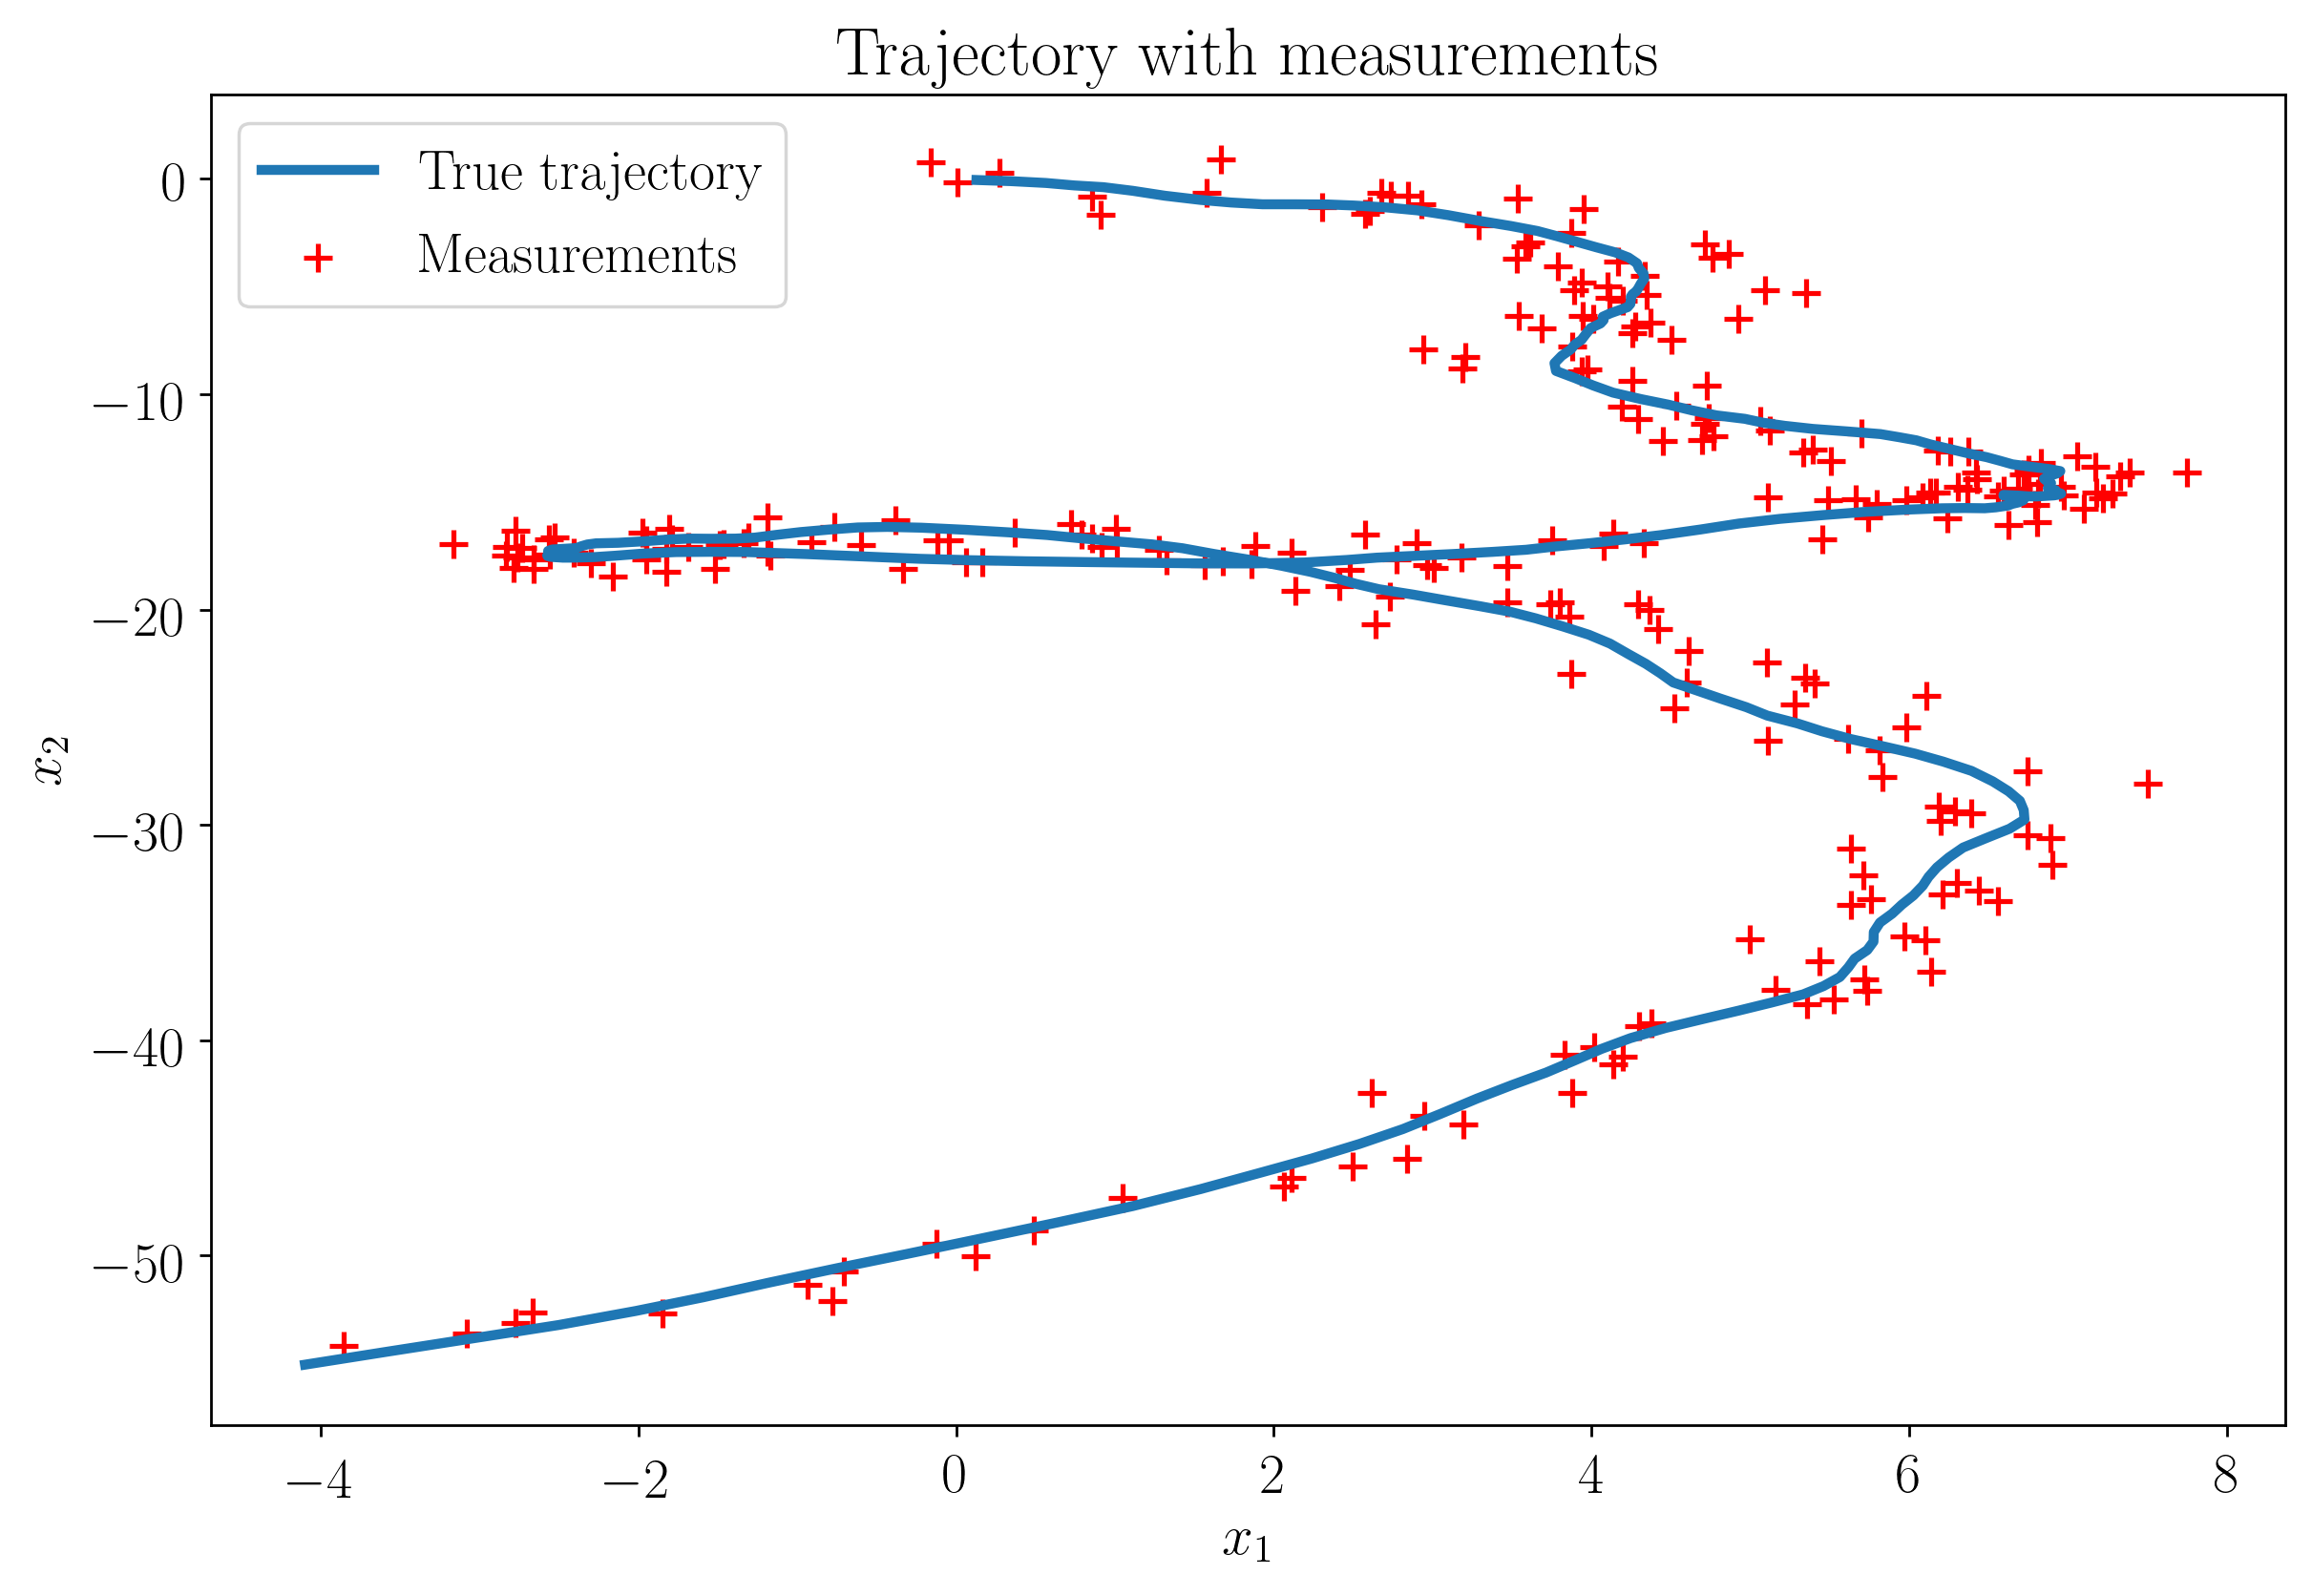

In [9]:
plot_s1(trj.X[0, :], trj.X[1, :], 
        'Trajectory with measurements',
        '$x_1$',
        '$x_2$',
        label='True trajectory',
        lw=3
       )
plt.scatter(trj.Y[0, :], trj.Y[1, :], marker='+', c='red', label='Measurements', s=70)
plt.legend()
savef('trajectory.pdf')

<Figure size 2500x1750 with 0 Axes>

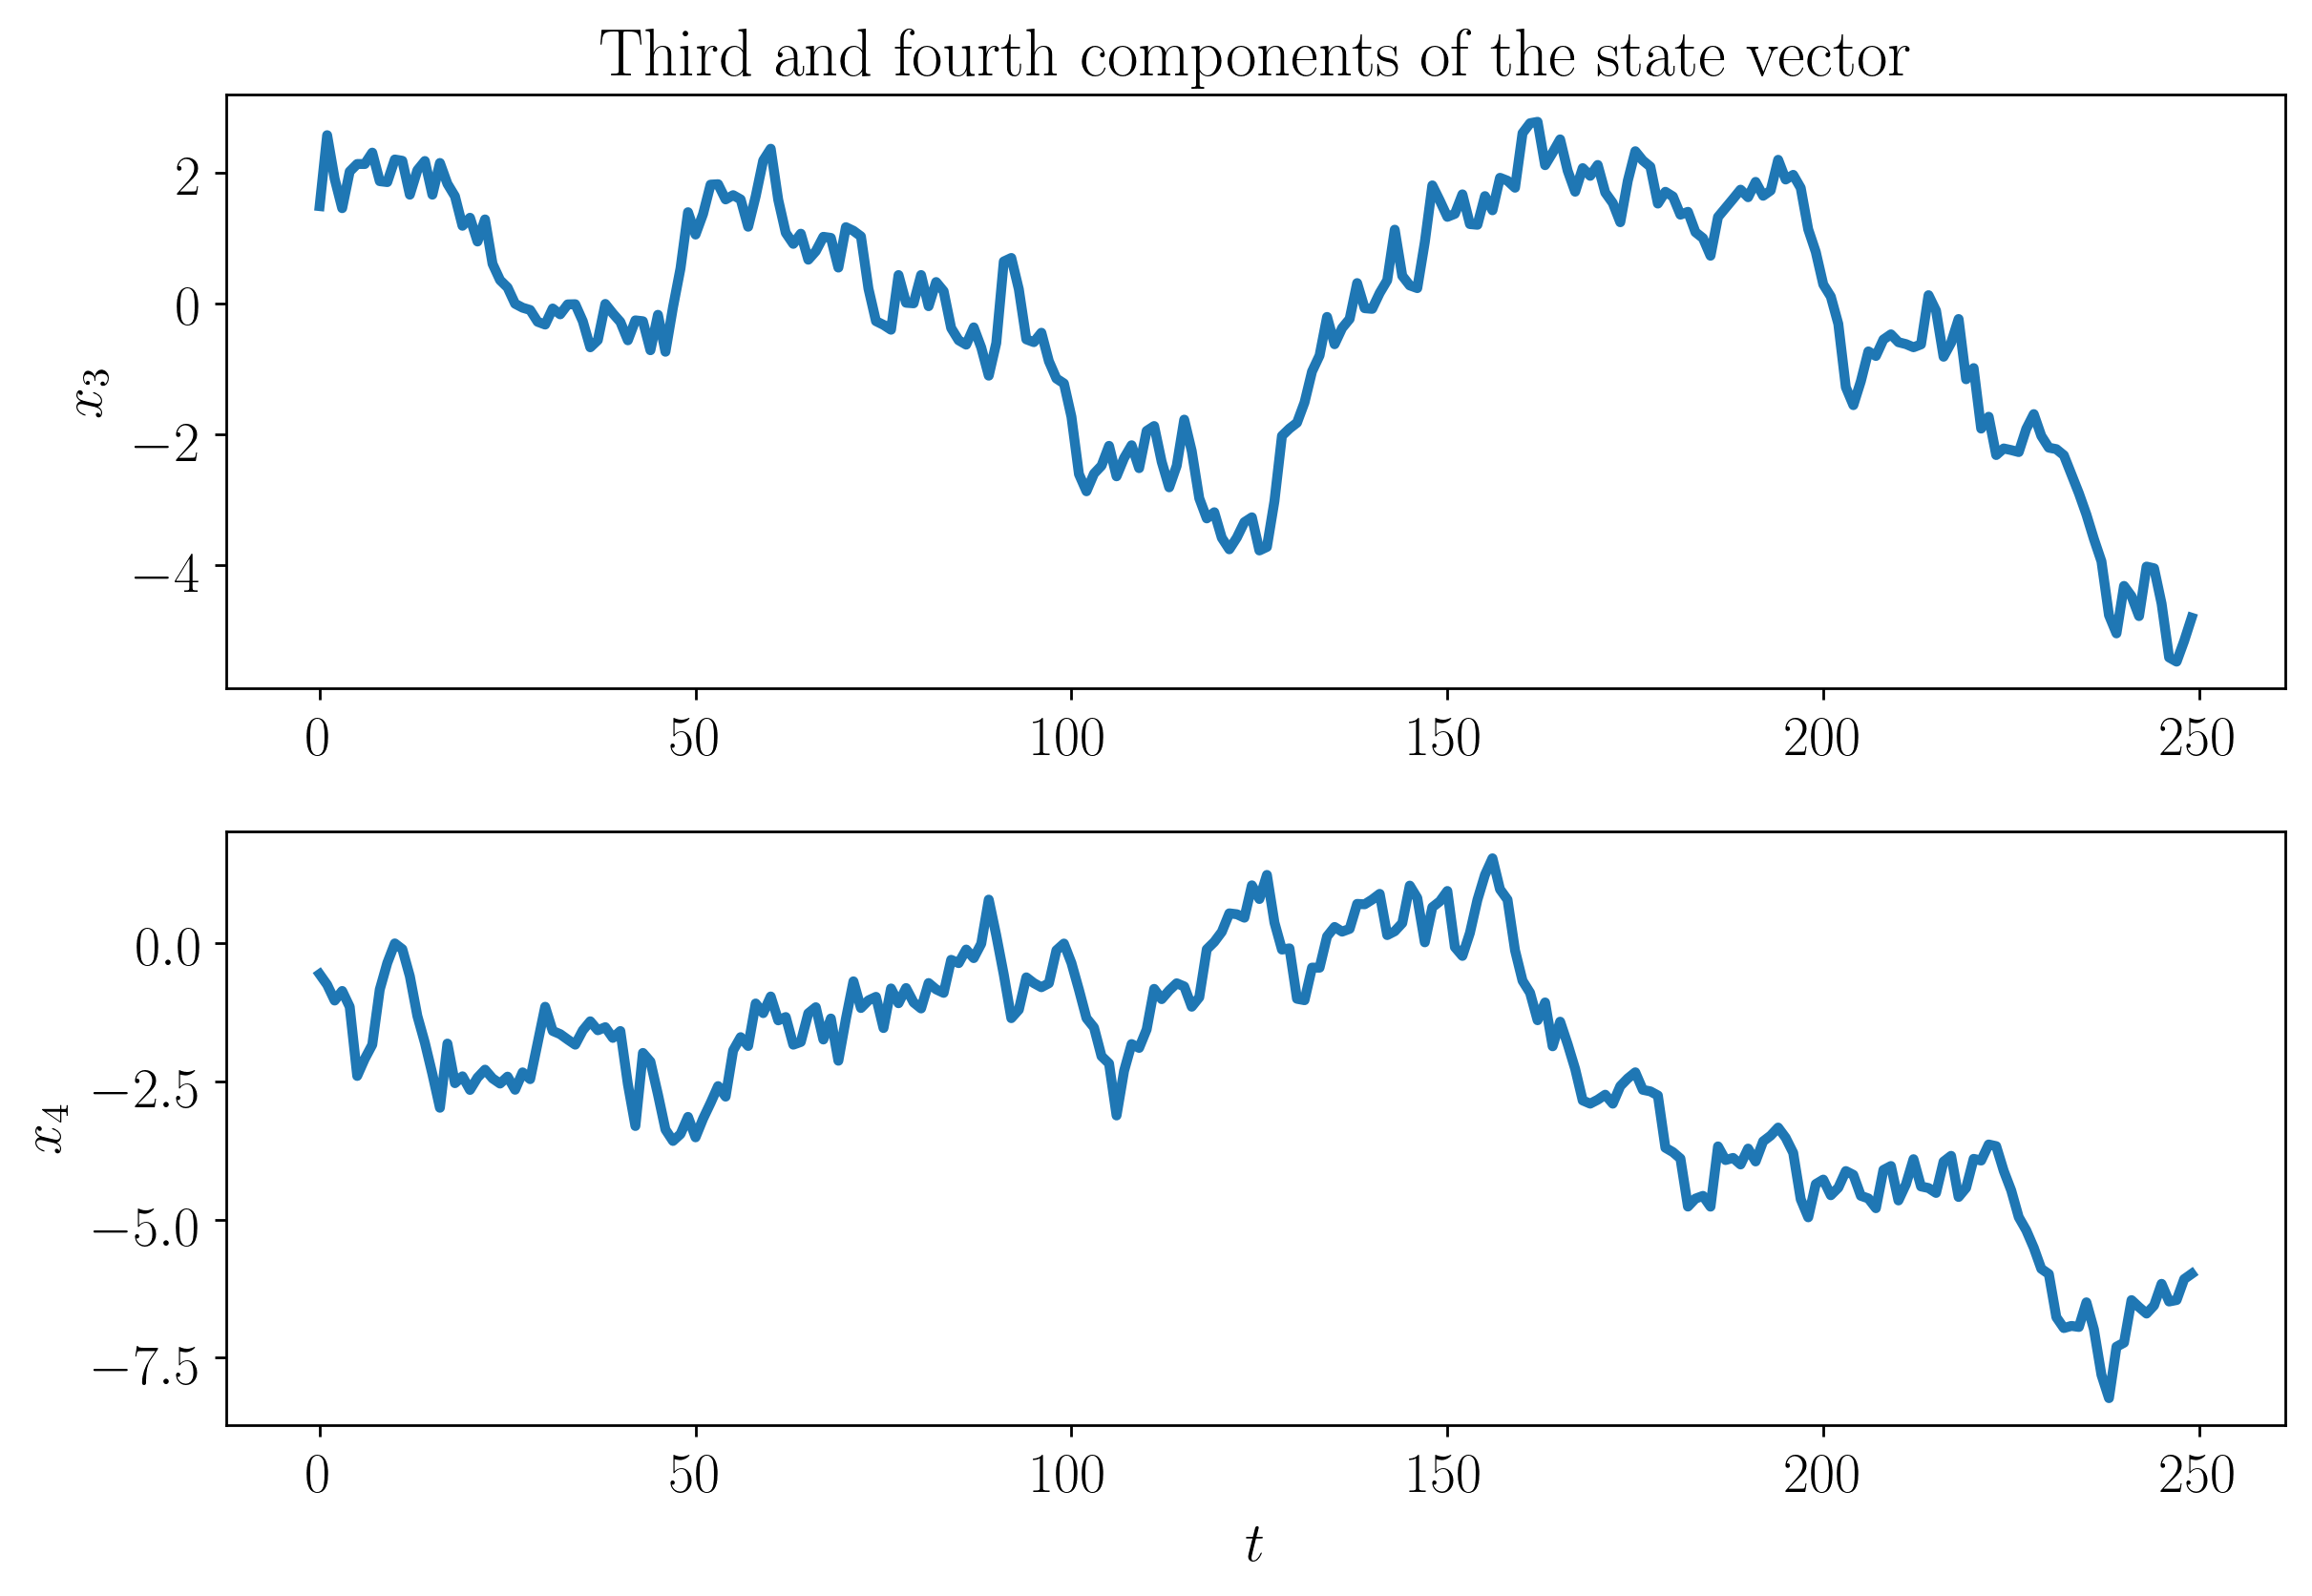

In [10]:
plt.figure()

f, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(trj.X[2, :], lw=3)
ax1.set_ylabel('$x_3$')
ax1.set_title('Third and fourth components of the state vector')

ax2.plot(trj.X[3, :], lw=3)
ax2.set_ylabel('$x_4$')
ax2.set_xlabel('$t$')

savef('3and4th-state.pdf')

# Noise

In [11]:
from kfsims import noise
import numpy as np

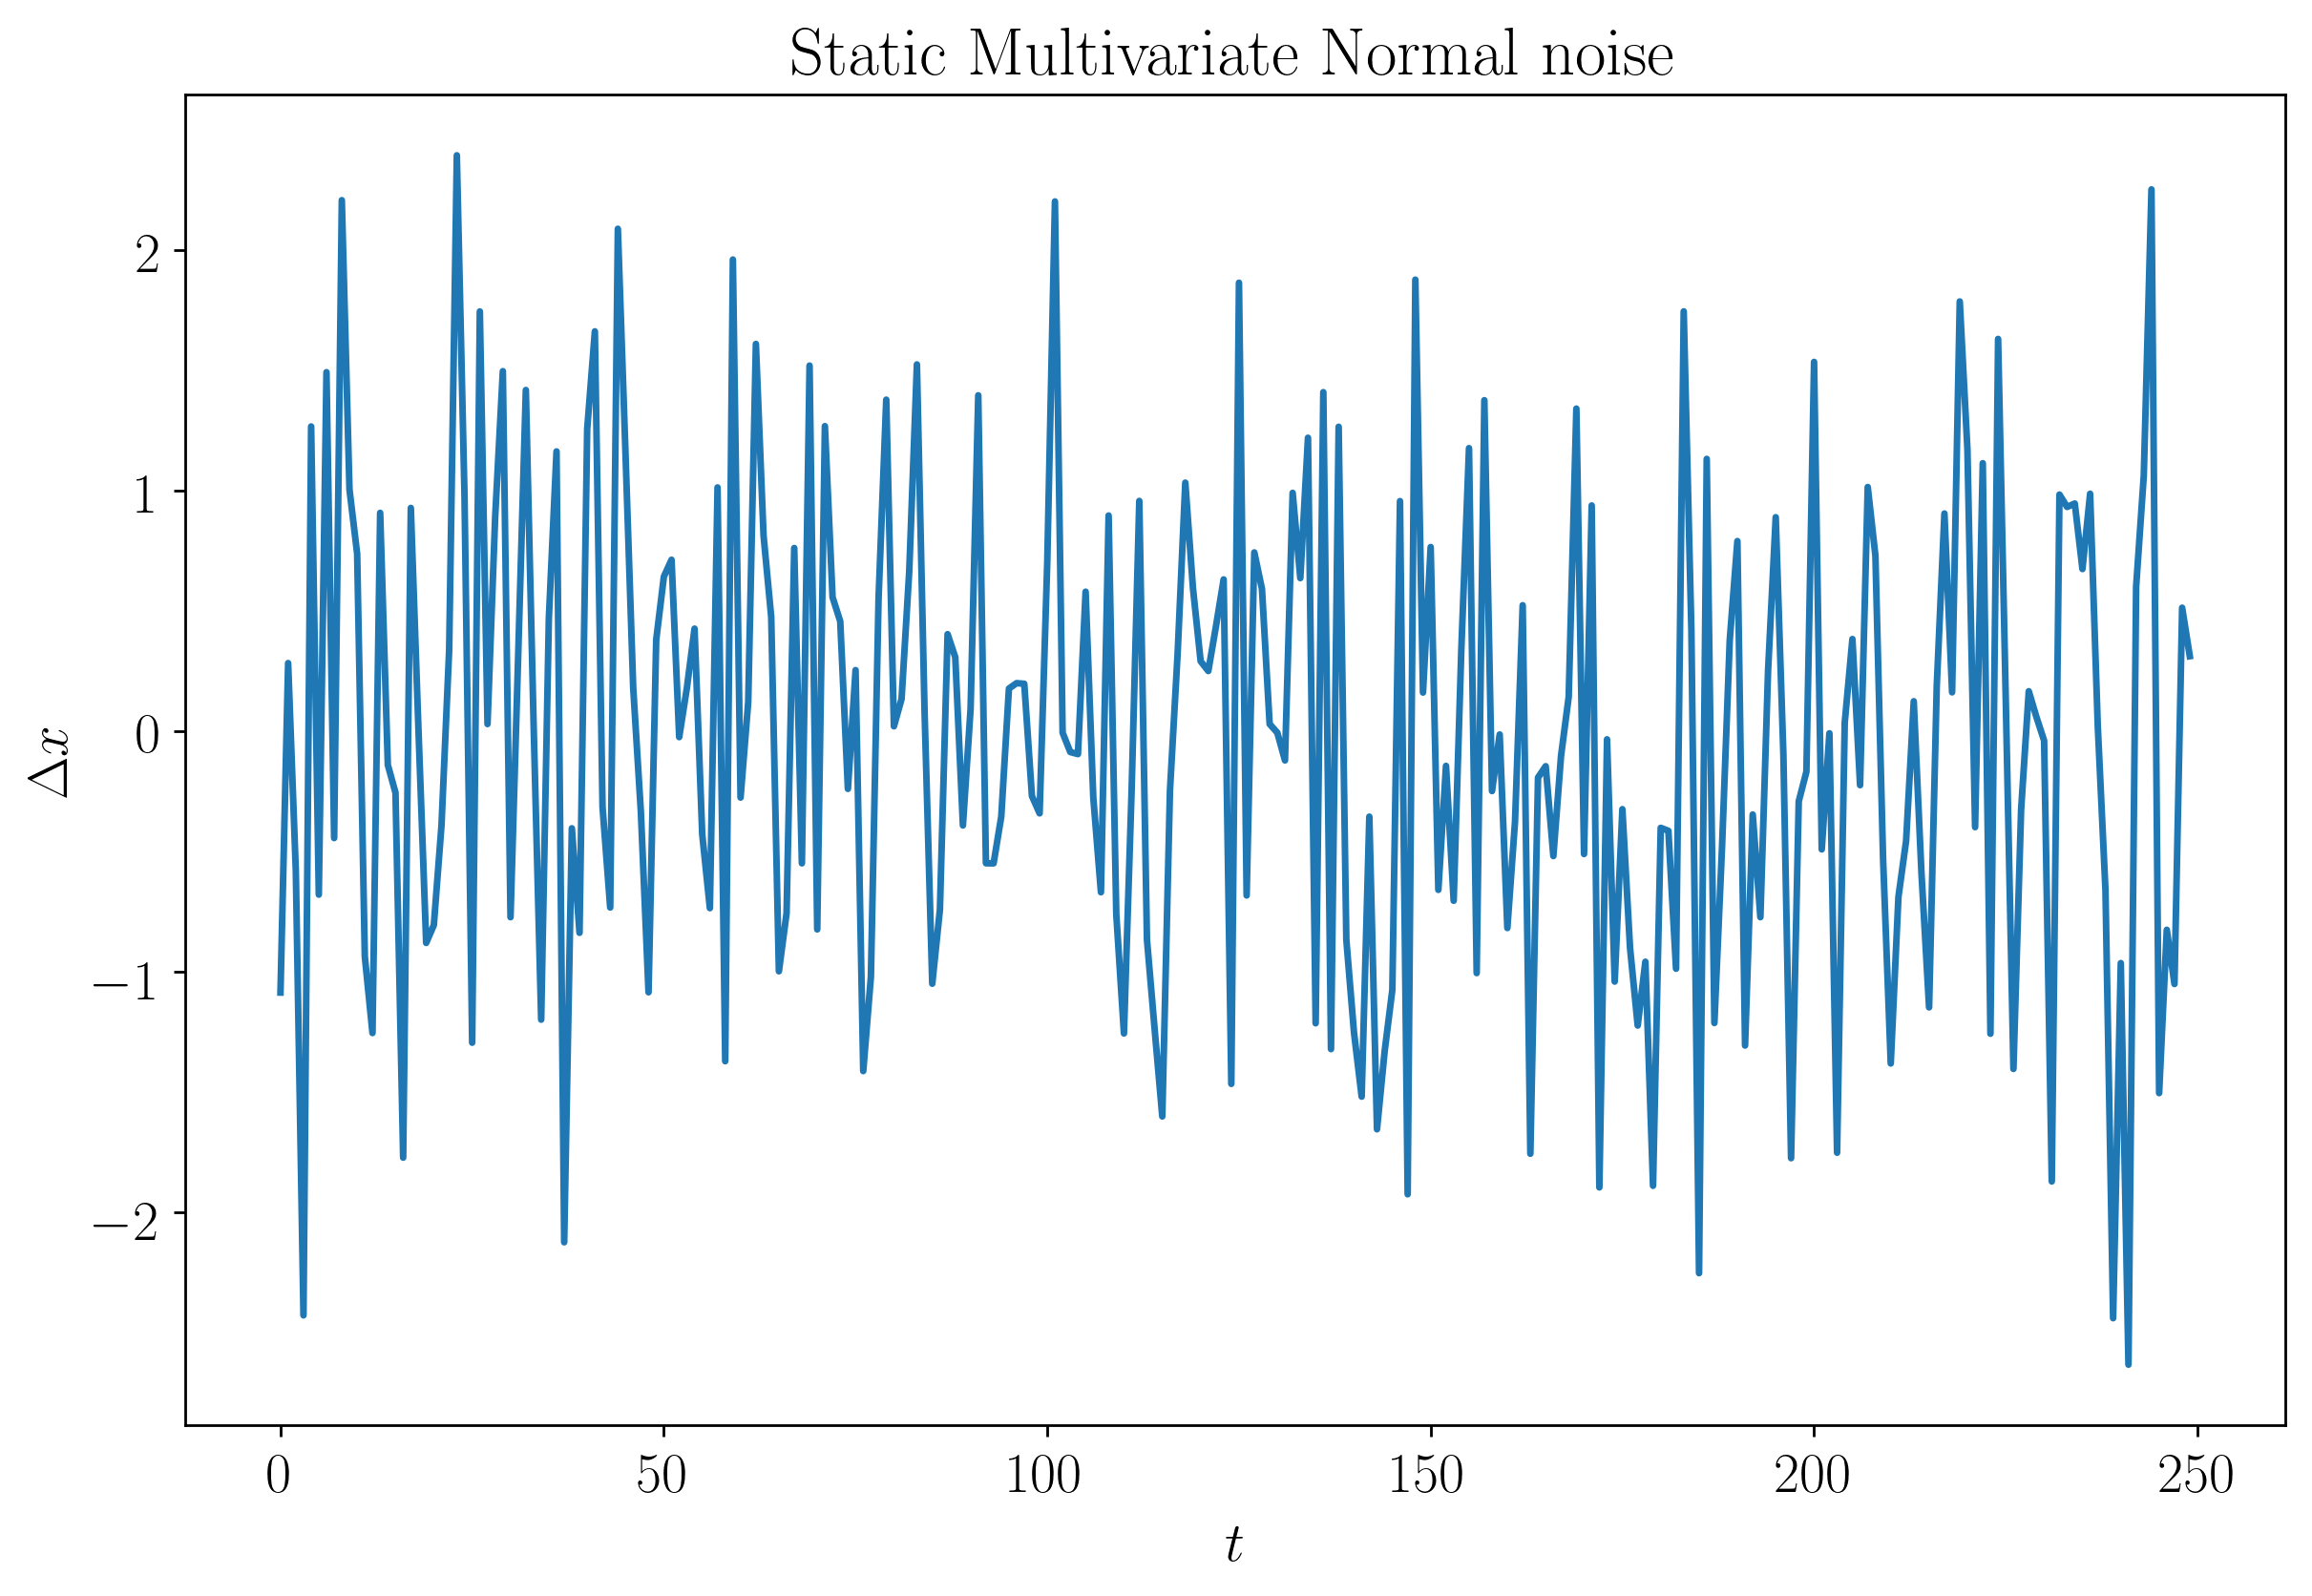

In [12]:
np.random.seed(SEED)
n_static = noise.static_noise(N)
x1 = n_static[:, 0]
plot_s1(range(len(x1)), x1, title='Static Multivariate Normal noise', xlabel='$t$', 
        ylabel="$\Delta x$", lw=2)
savef('static-noise.pdf')

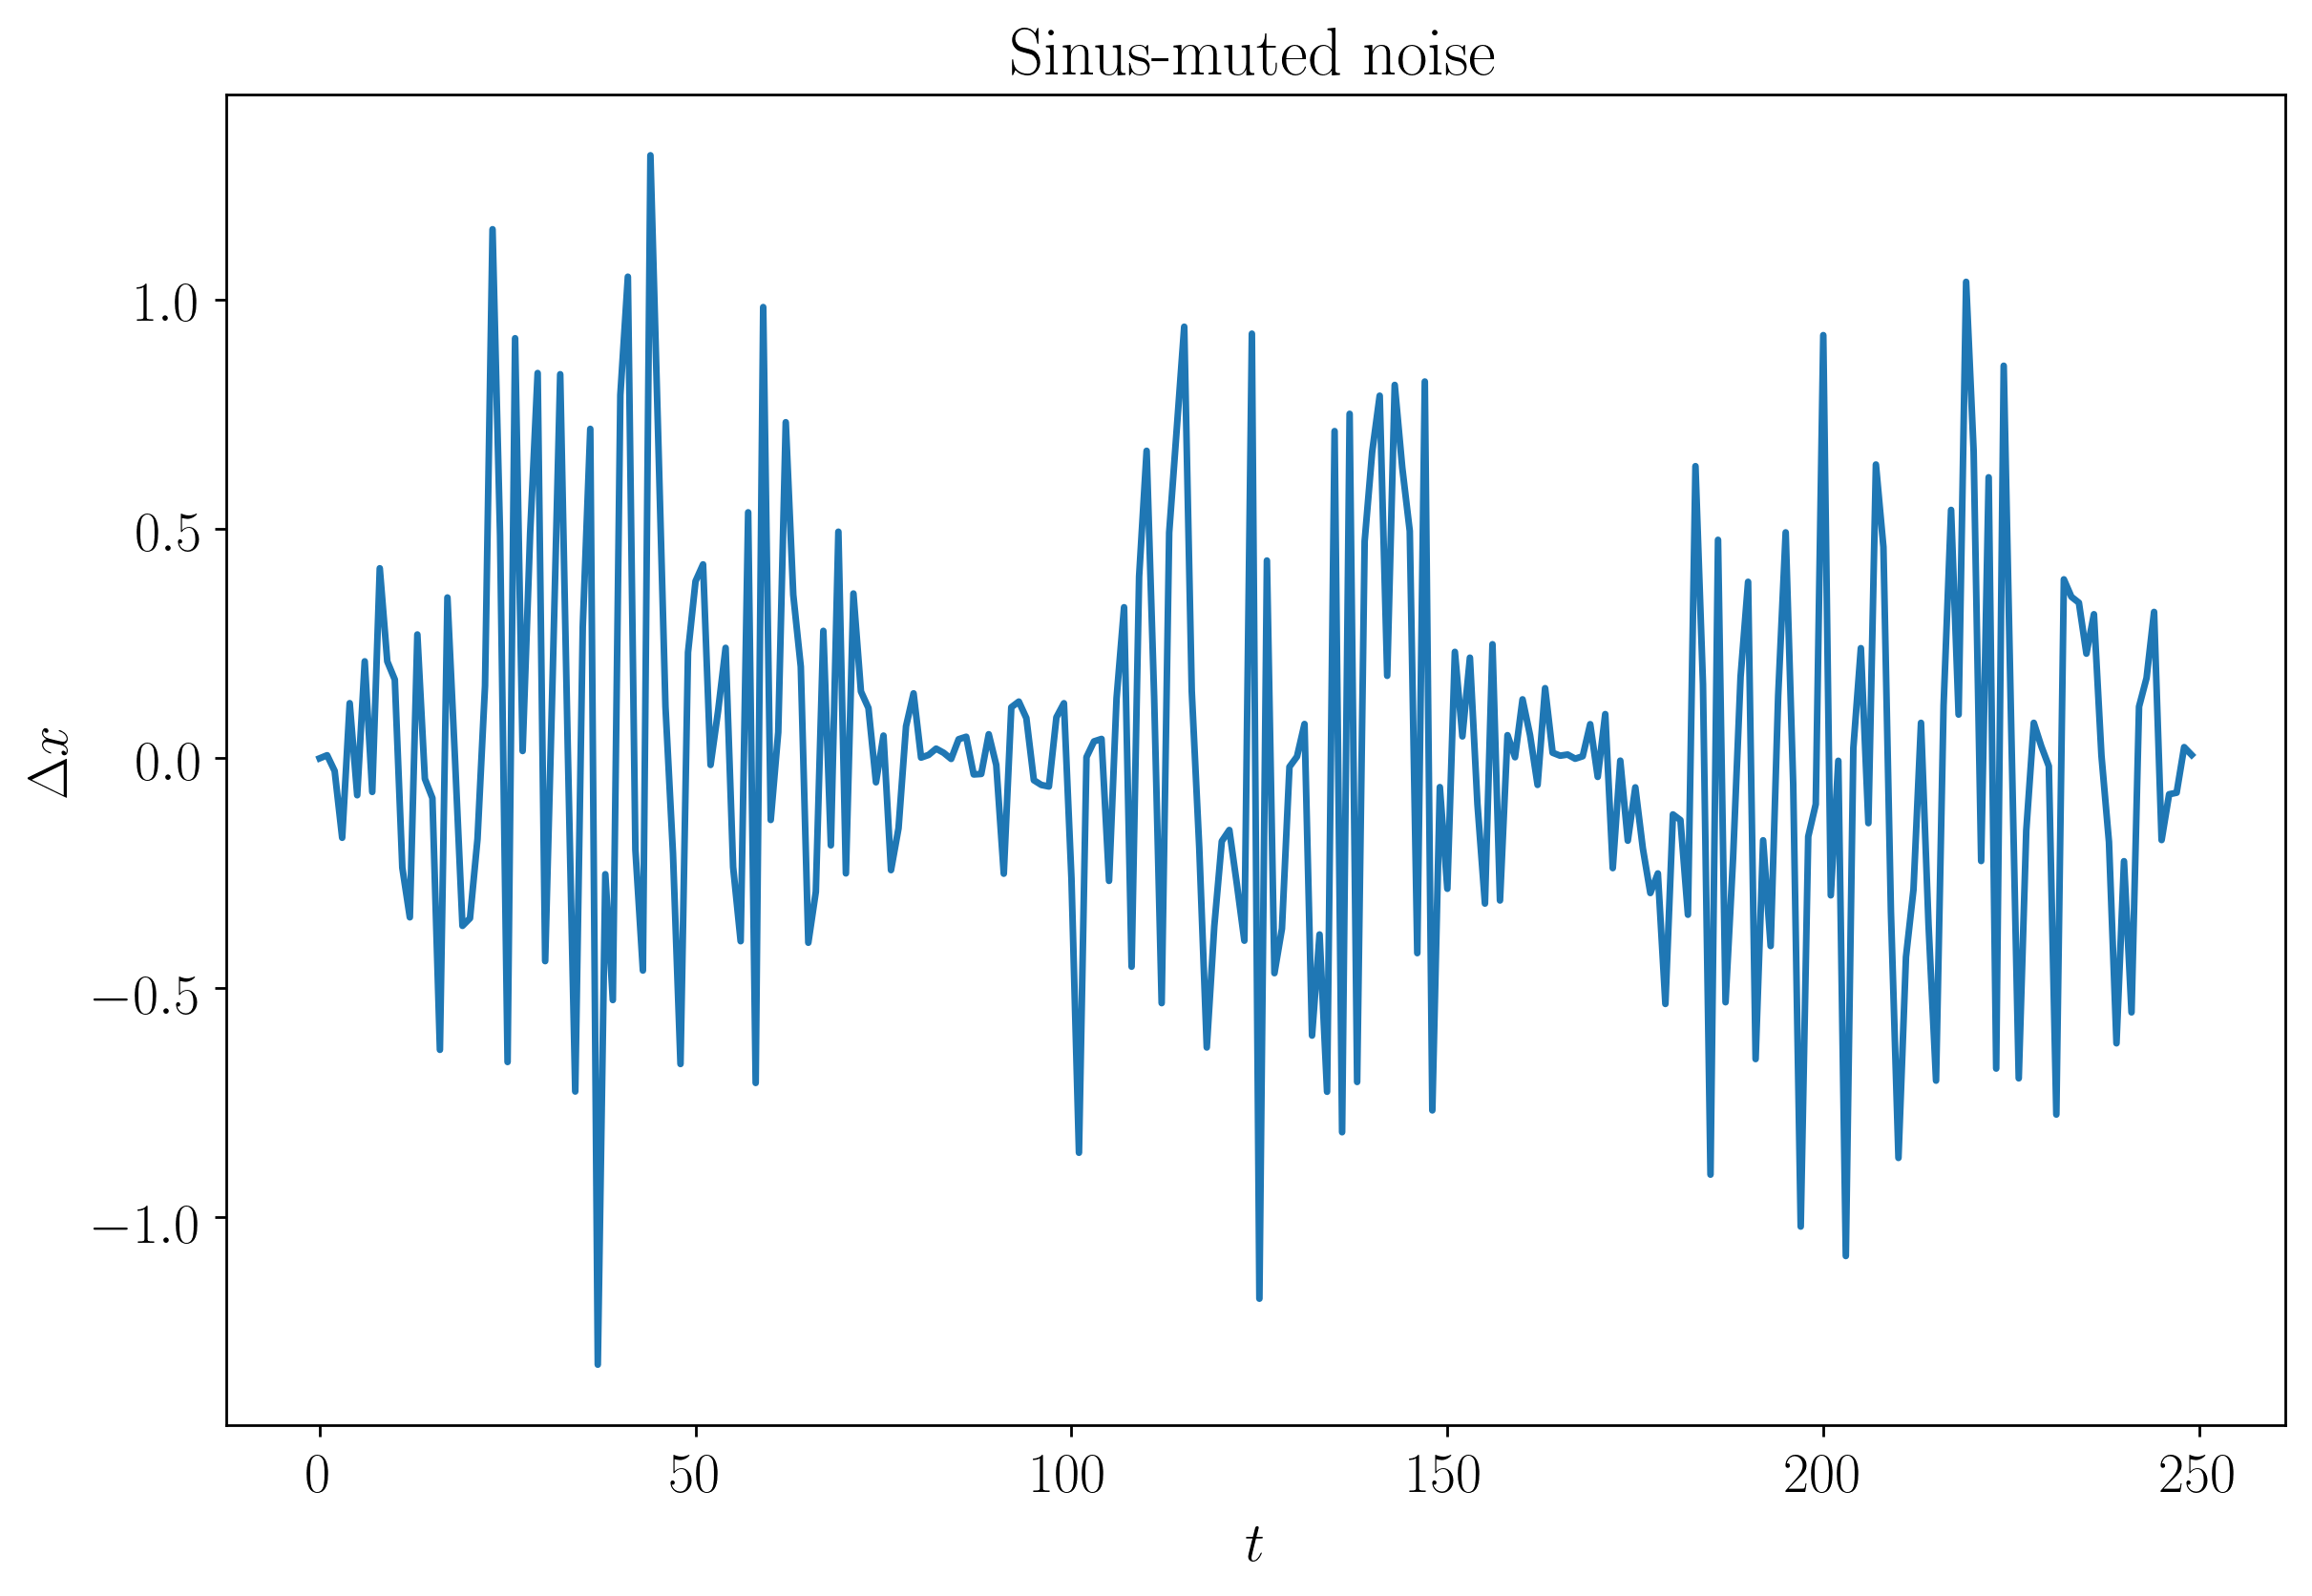

In [13]:
np.random.seed(SEED)
n_sin = (noise.static_noise(N, mod=0.4) * noise.sin_noise(N, 3))[:, 0]
plot_s1(range(len(n_sin)), n_sin, title='Sinus-muted noise', 
        xlabel='$t$', 
        ylabel="$\Delta x$", lw=2)
savef('sinus-noise.pdf')

# Known - static

In [315]:
from kfsims.utils import daniels_variant, classic_kf, plot_single, plot_variants_only, plot_variants

In [318]:
np.random.seed(10)
n_static = noise.static_noise(N, mod=8)

cov_init = abs(np.cov(n_static.T)) + cov_traj# + np.eye(2)*30
msrms = trj.Y + n_static.T

res_dv, rms_dv, std_dv = daniels_variant(msrms, true_traj, cov_init)
res_kfc, rms_kfc, srd_kfc  = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv, std_dv)
print(rms_kfc, srd_kfc)

[0.813 0.725 1.031 1.079] [0.661 0.556 0.865 0.813]
[0.751 0.707 1.014 0.992] [0.644 0.524 0.865 0.804]


In [319]:
cov_init

array([[7.64585125, 0.23195399],
       [0.23195399, 7.15207122]])

In [320]:
def plot_comp(plt, sl, res_dv, res_kfc, true_traj, msrms, title, ylabel, xlabel='$t$', start_pos=0):
    plot_single(plt, sl, res_dv, res_kfc, true_traj, msrms, start_pos=start_pos)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

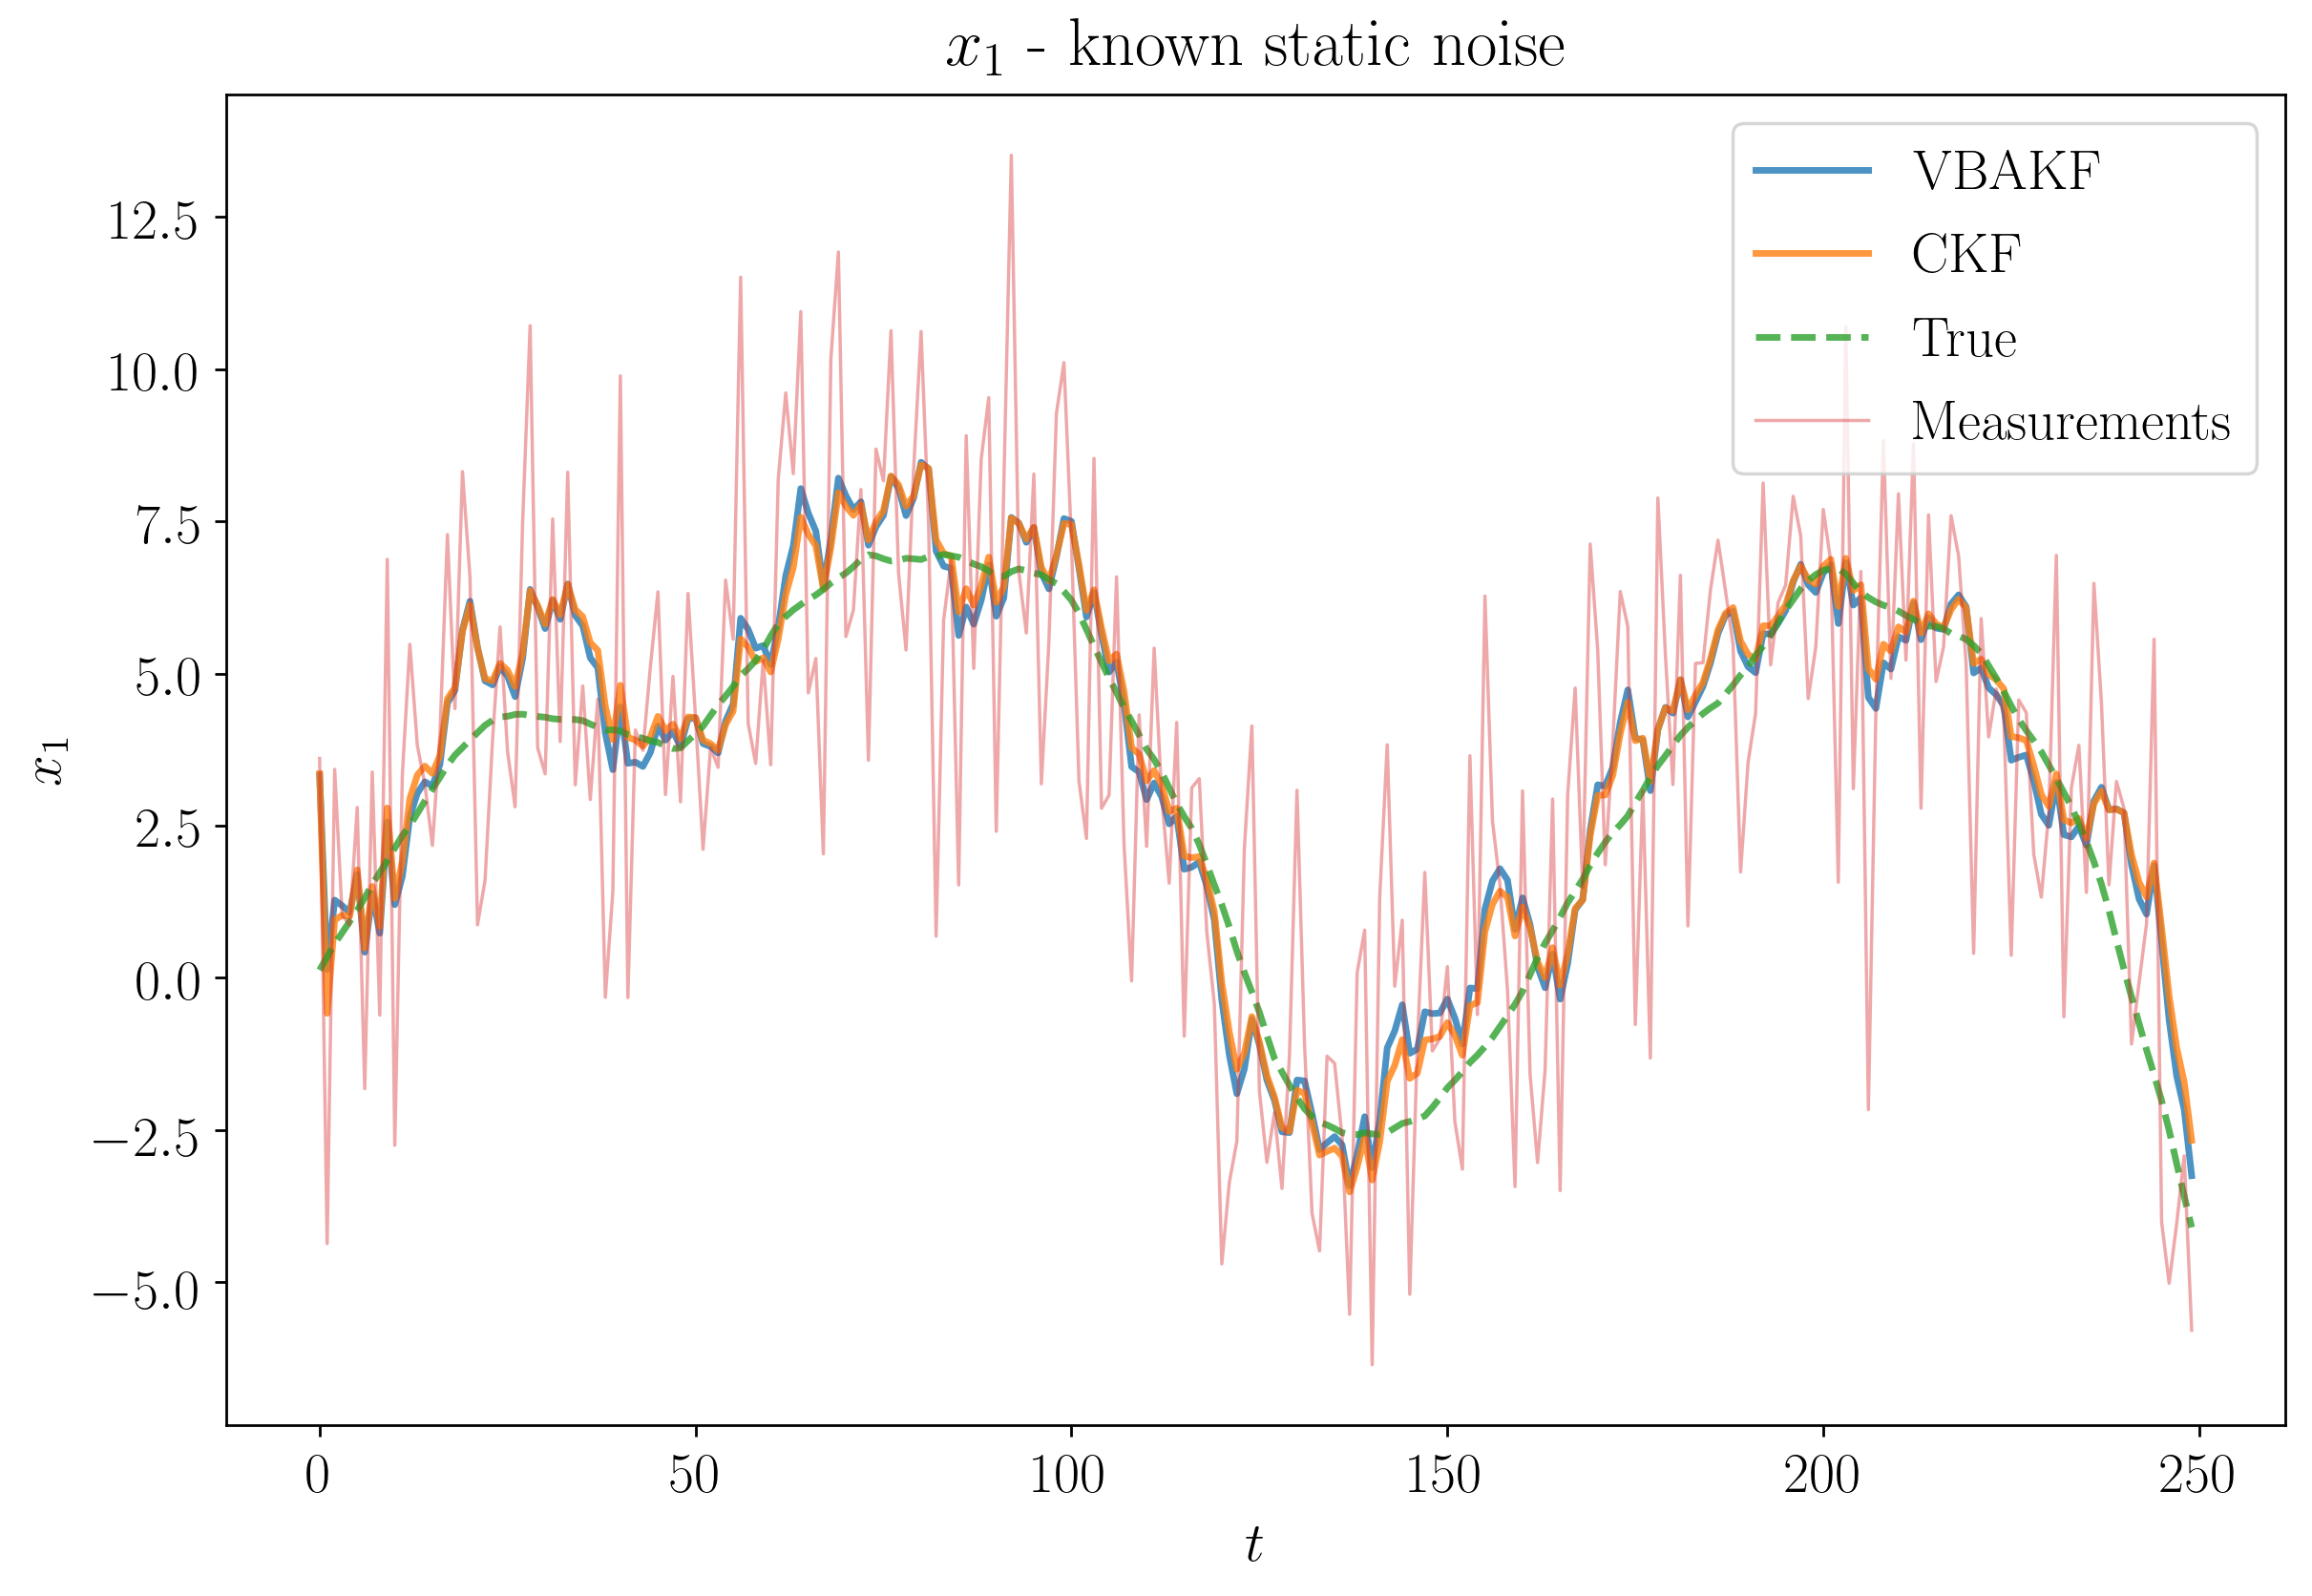

In [321]:
plot_comp(plt, 0, res_dv, res_kfc, true_traj, msrms, '$x_1$ - known static noise', '$x_1$')
savef('perf-static-known-x1.pdf')

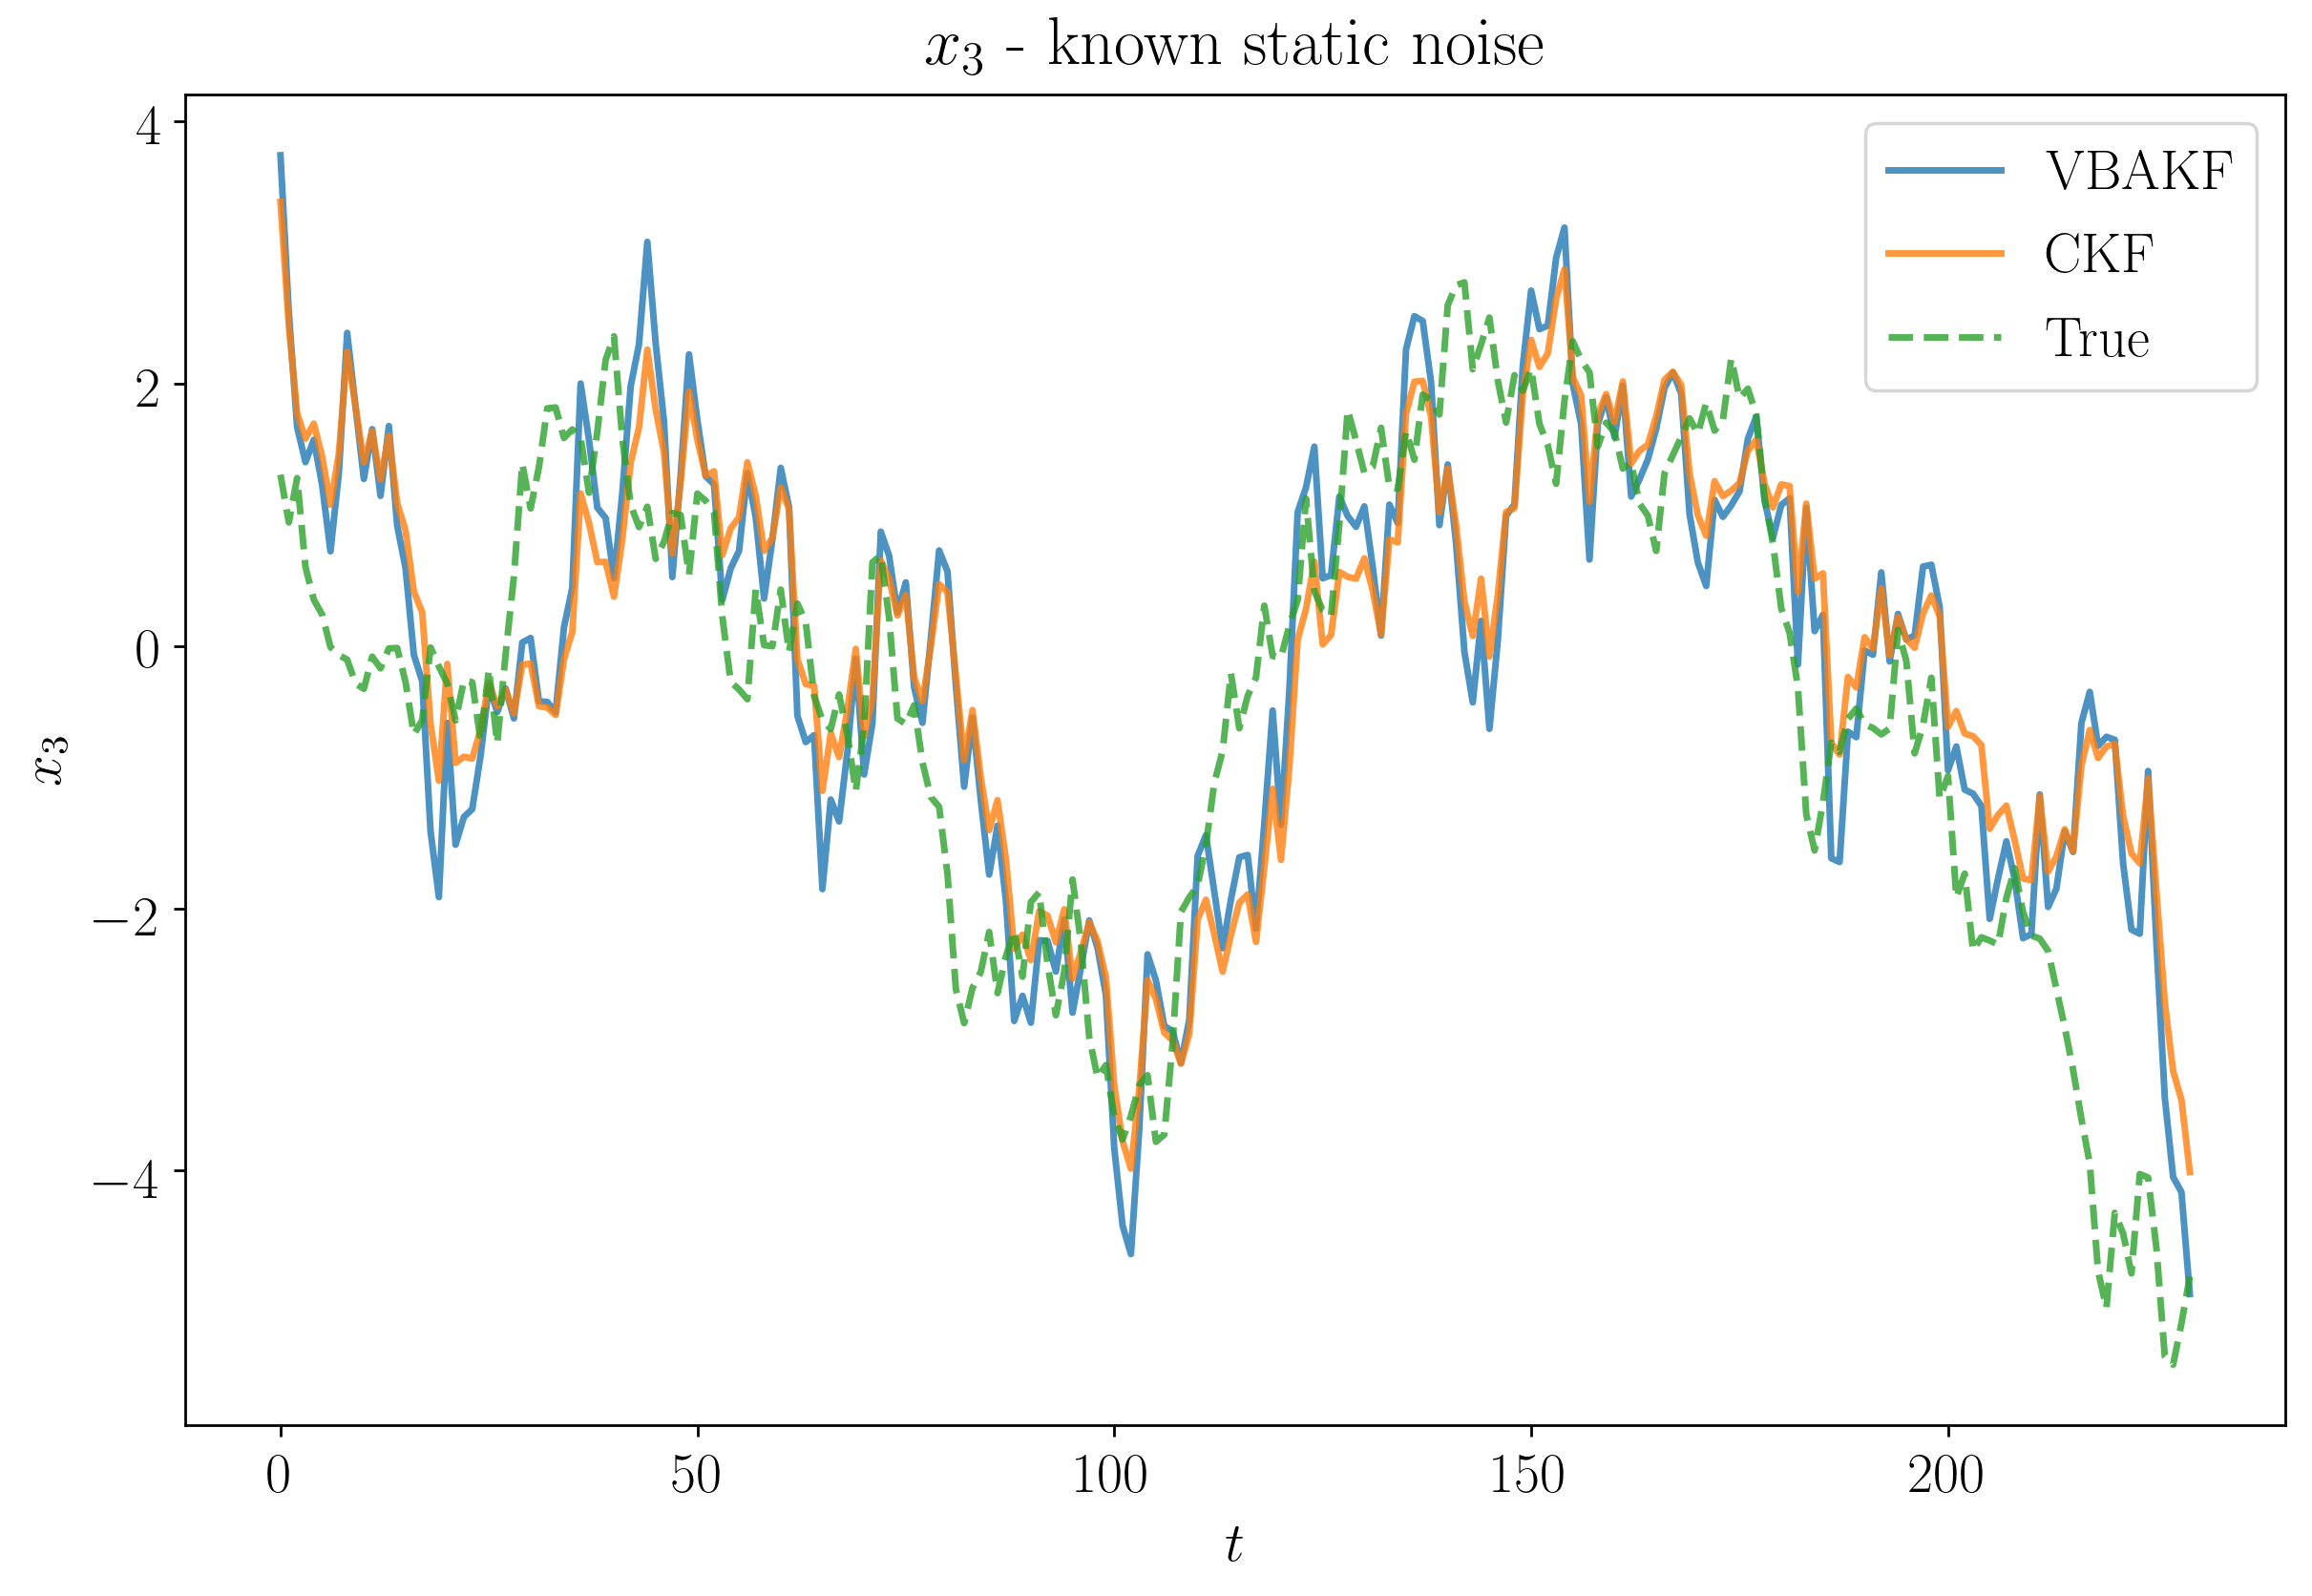

In [322]:
plot_comp(plt, 2, res_dv, res_kfc, true_traj, msrms=None, title='$x_3$ - known static noise', ylabel='$x_3$',
         start_pos=20)
savef('perf-static-known-x3.pdf')

In [323]:
from kfsims.utils import hists_subplots

In [324]:
import pandas as pd
import seaborn as sns

dt_sn = np.concatenate([rms_dv, rms_kfc])
dts_sn = np.concatenate([std_dv, srd_kfc])

df_sn = pd.DataFrame(
    {'RMSE': dt_sn,
     'STD': dts_sn,
     'Component': [f'$x_{i}$' for i in range(1, 5)]*2,
     'Algorithm': ['VBAKF']*4 + ['CKF']*4,
    })

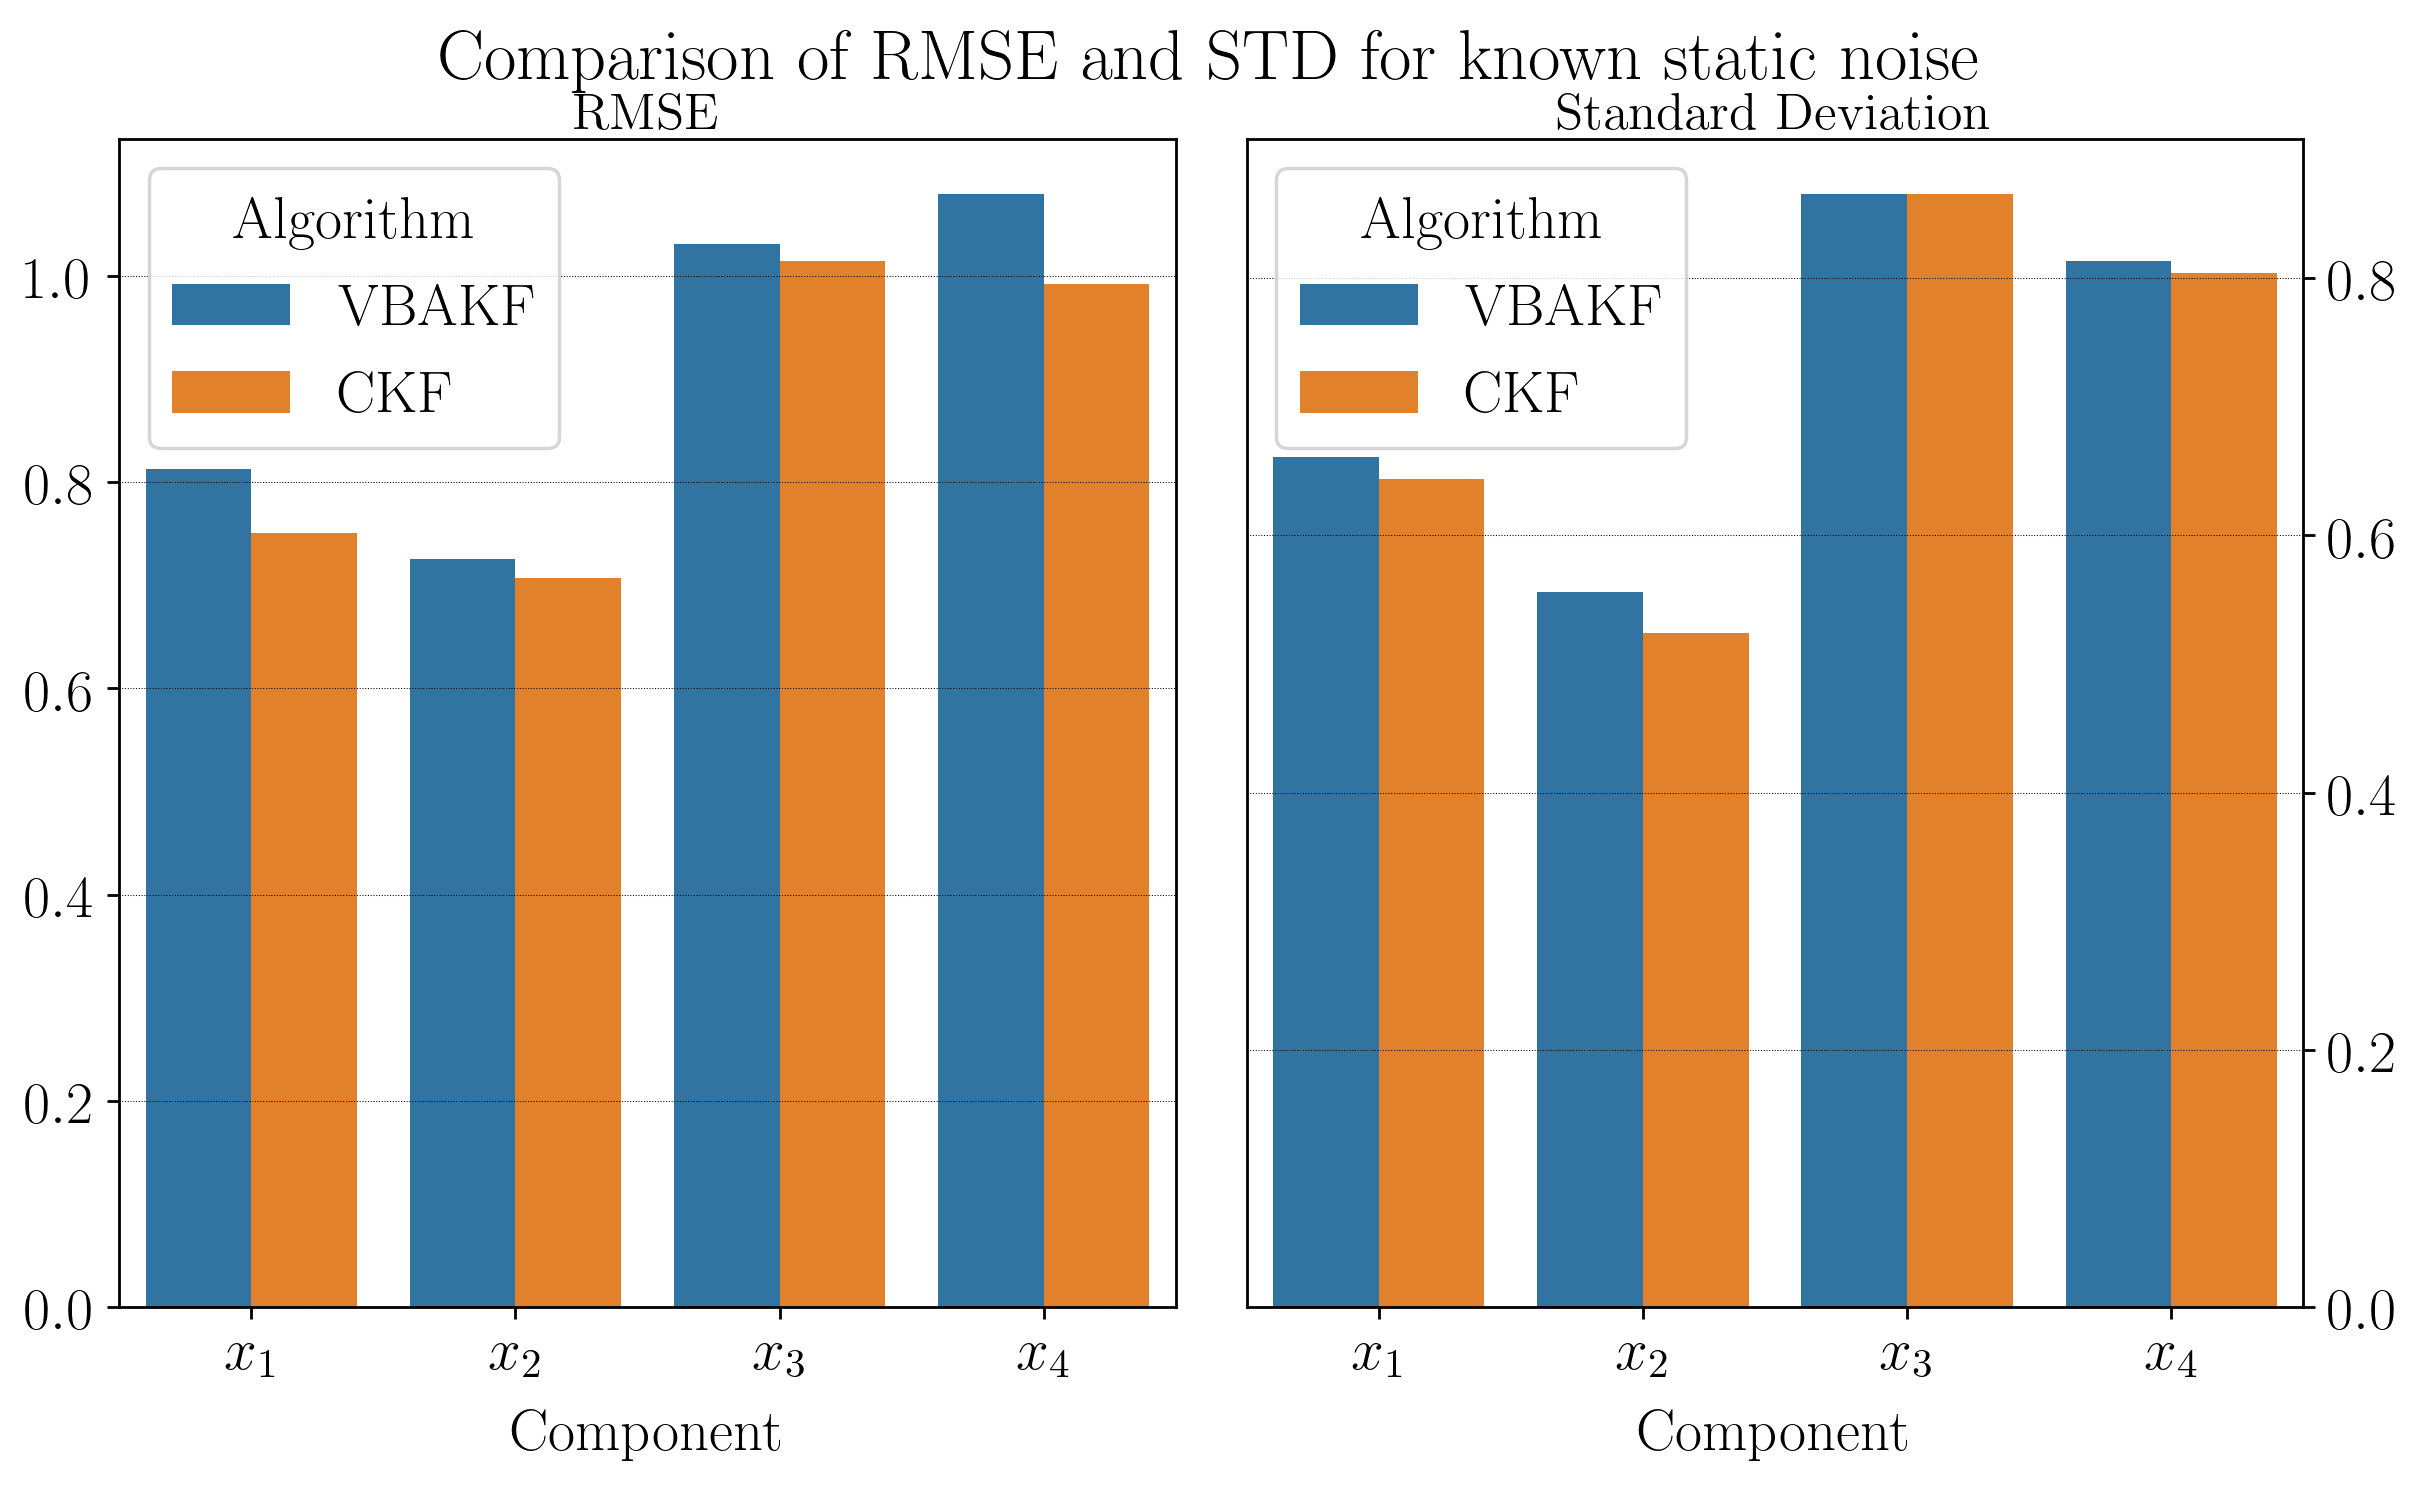

In [325]:
hists_subplots(df_sn, "known static noise")
savef('bars-known-static-noise.pdf')

# Unknown static

In [326]:
np.random.seed(10)
n_static = noise.static_noise(N, mod=8)

cov_init = abs(cov_traj) # np.cov(n_static.T)
msrms = trj.Y + n_static.T

res_dv, rms_dv, std_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.99)
res_kfc, rms_kfc, srd_kfc  = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv, std_dv)
print(rms_kfc, srd_kfc)

[0.872 0.78  1.26  1.242] [0.734 0.616 1.334 1.437]
[1.099 1.04  2.241 2.311] [0.902 0.785 3.696 2.095]


In [327]:
import pandas as pd
import seaborn as sns

dt_us = np.concatenate([rms_dv, rms_kfc])
dts_us = np.concatenate([std_dv, srd_kfc])

df_us = pd.DataFrame(
    {'RMSE': dt_us,
     'STD': dts_us,
     'Component': [f'$x_{i}$' for i in range(1, 5)]*2,
     'Algorithm': ['VBAKF']*4 + ['CKF']*4,
    })

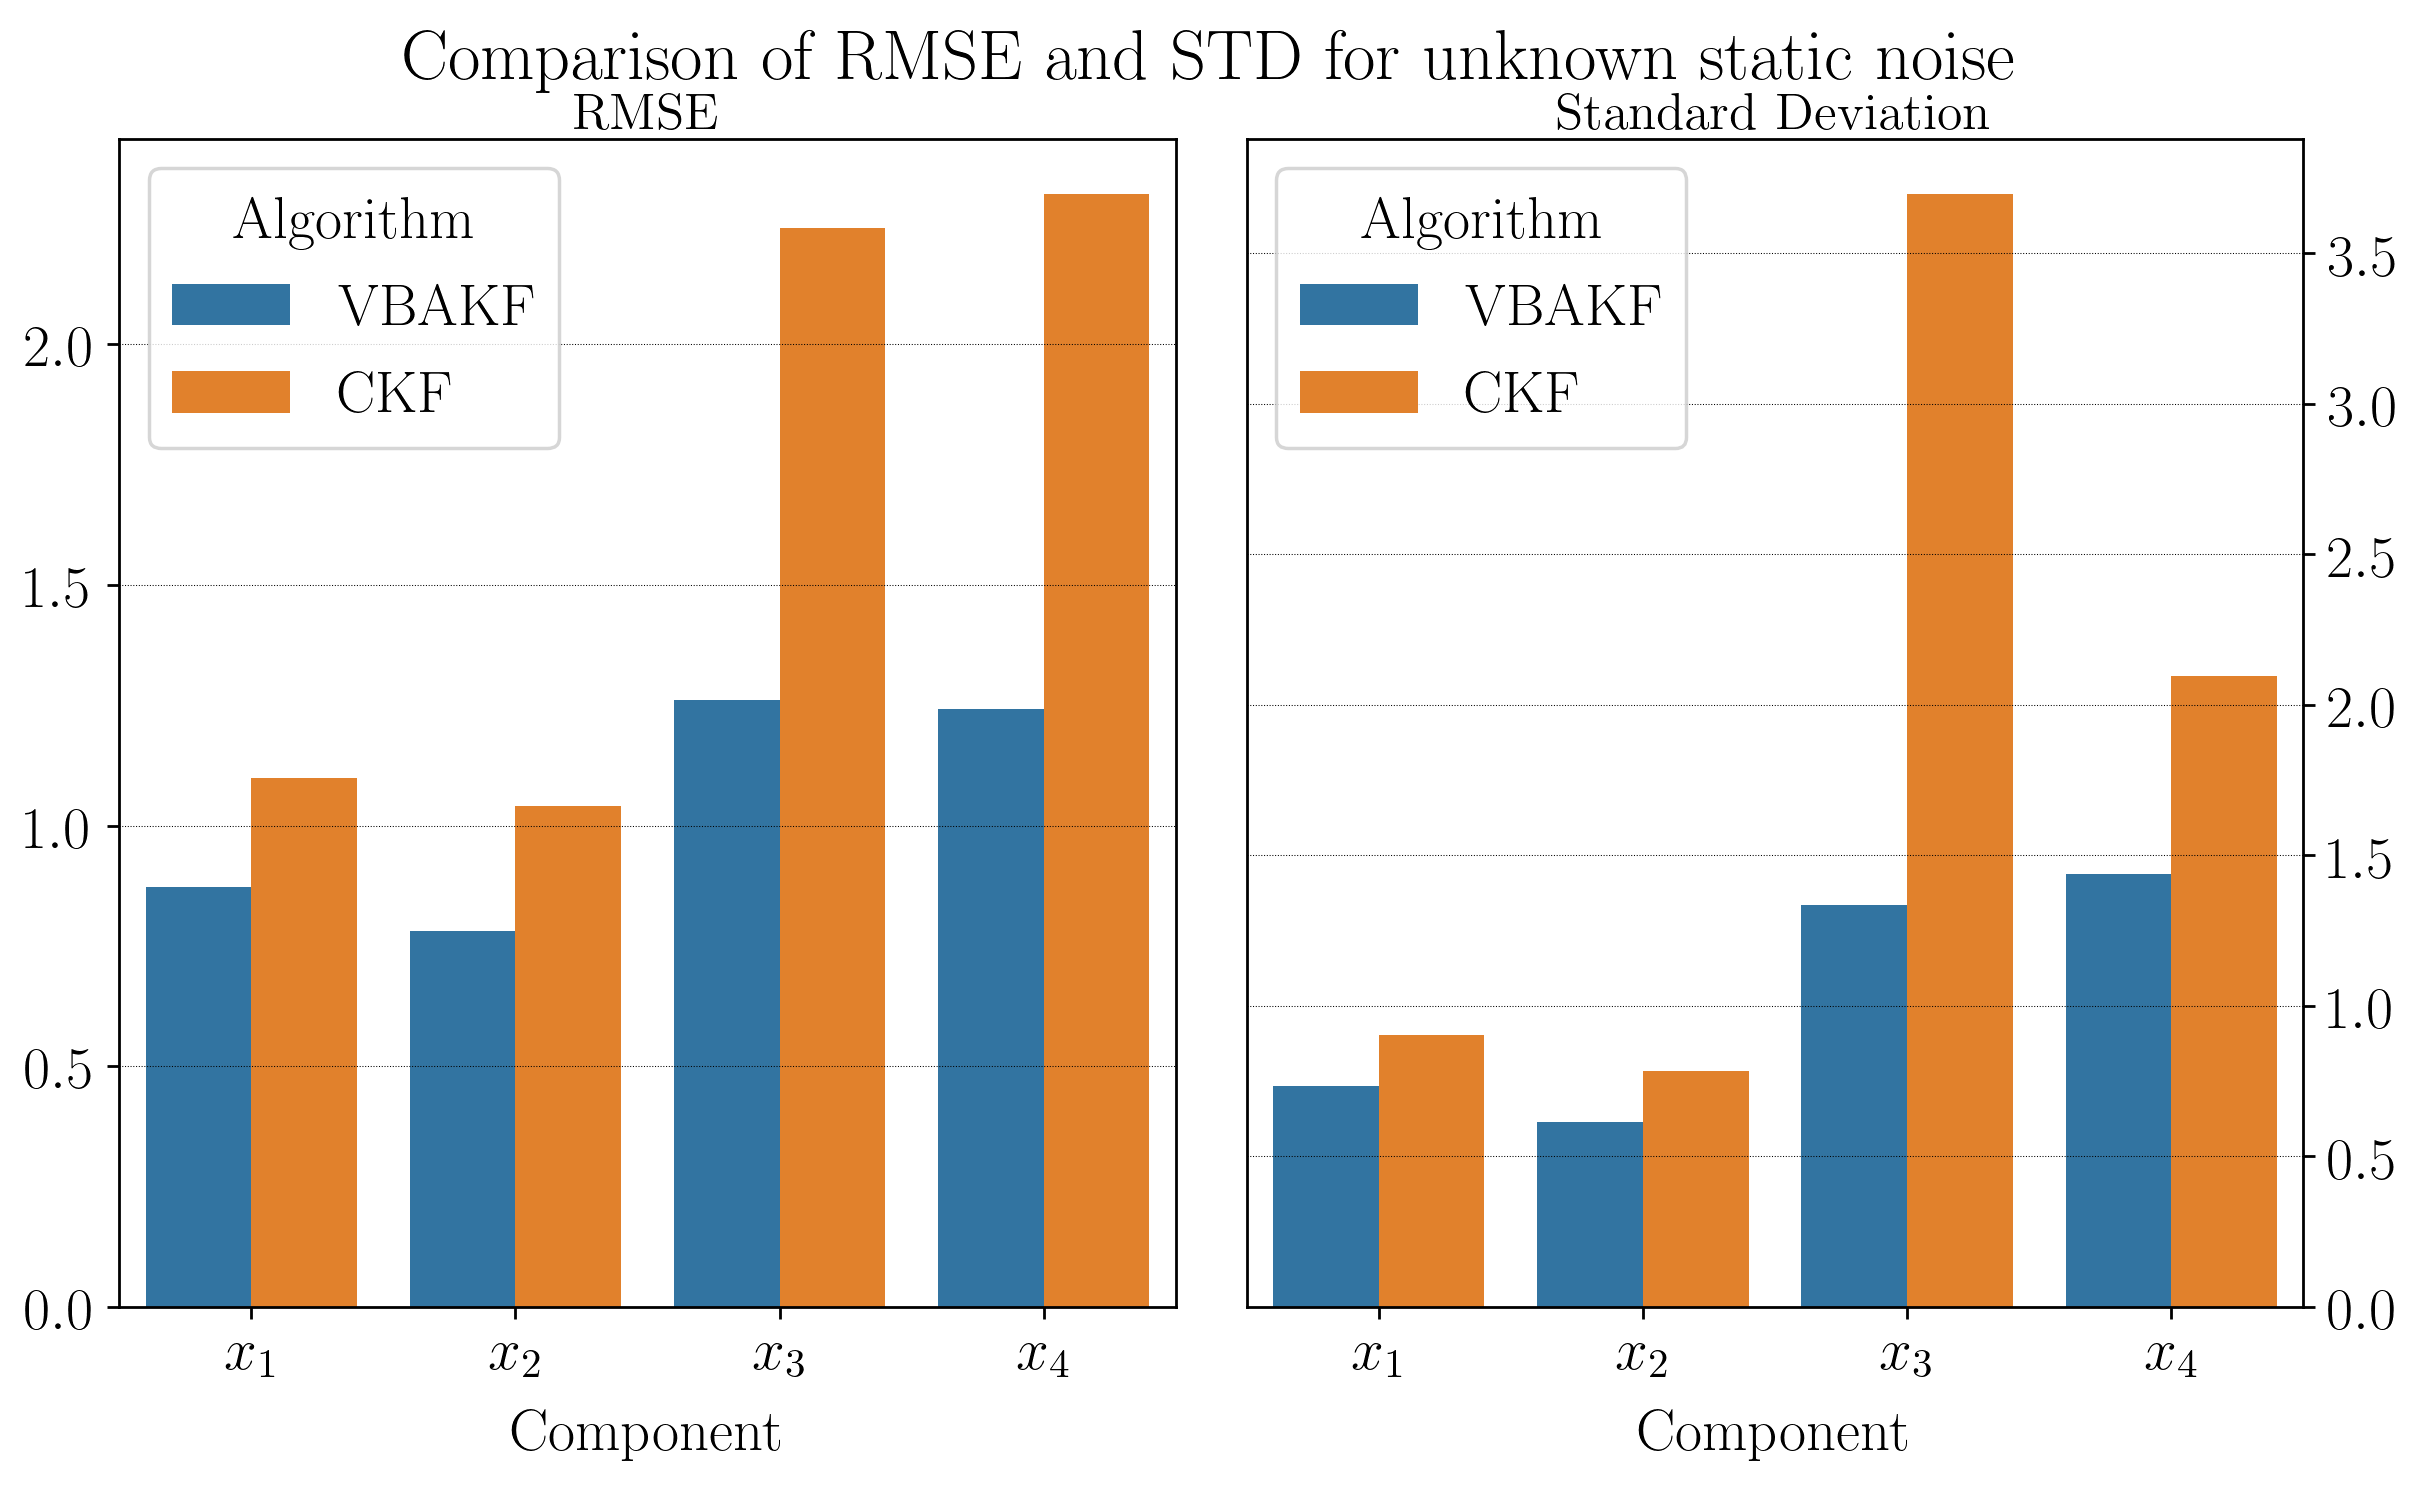

In [328]:
hists_subplots(df_us, 'unknown static noise')
savef('bars-unknown-static-noise.pdf')

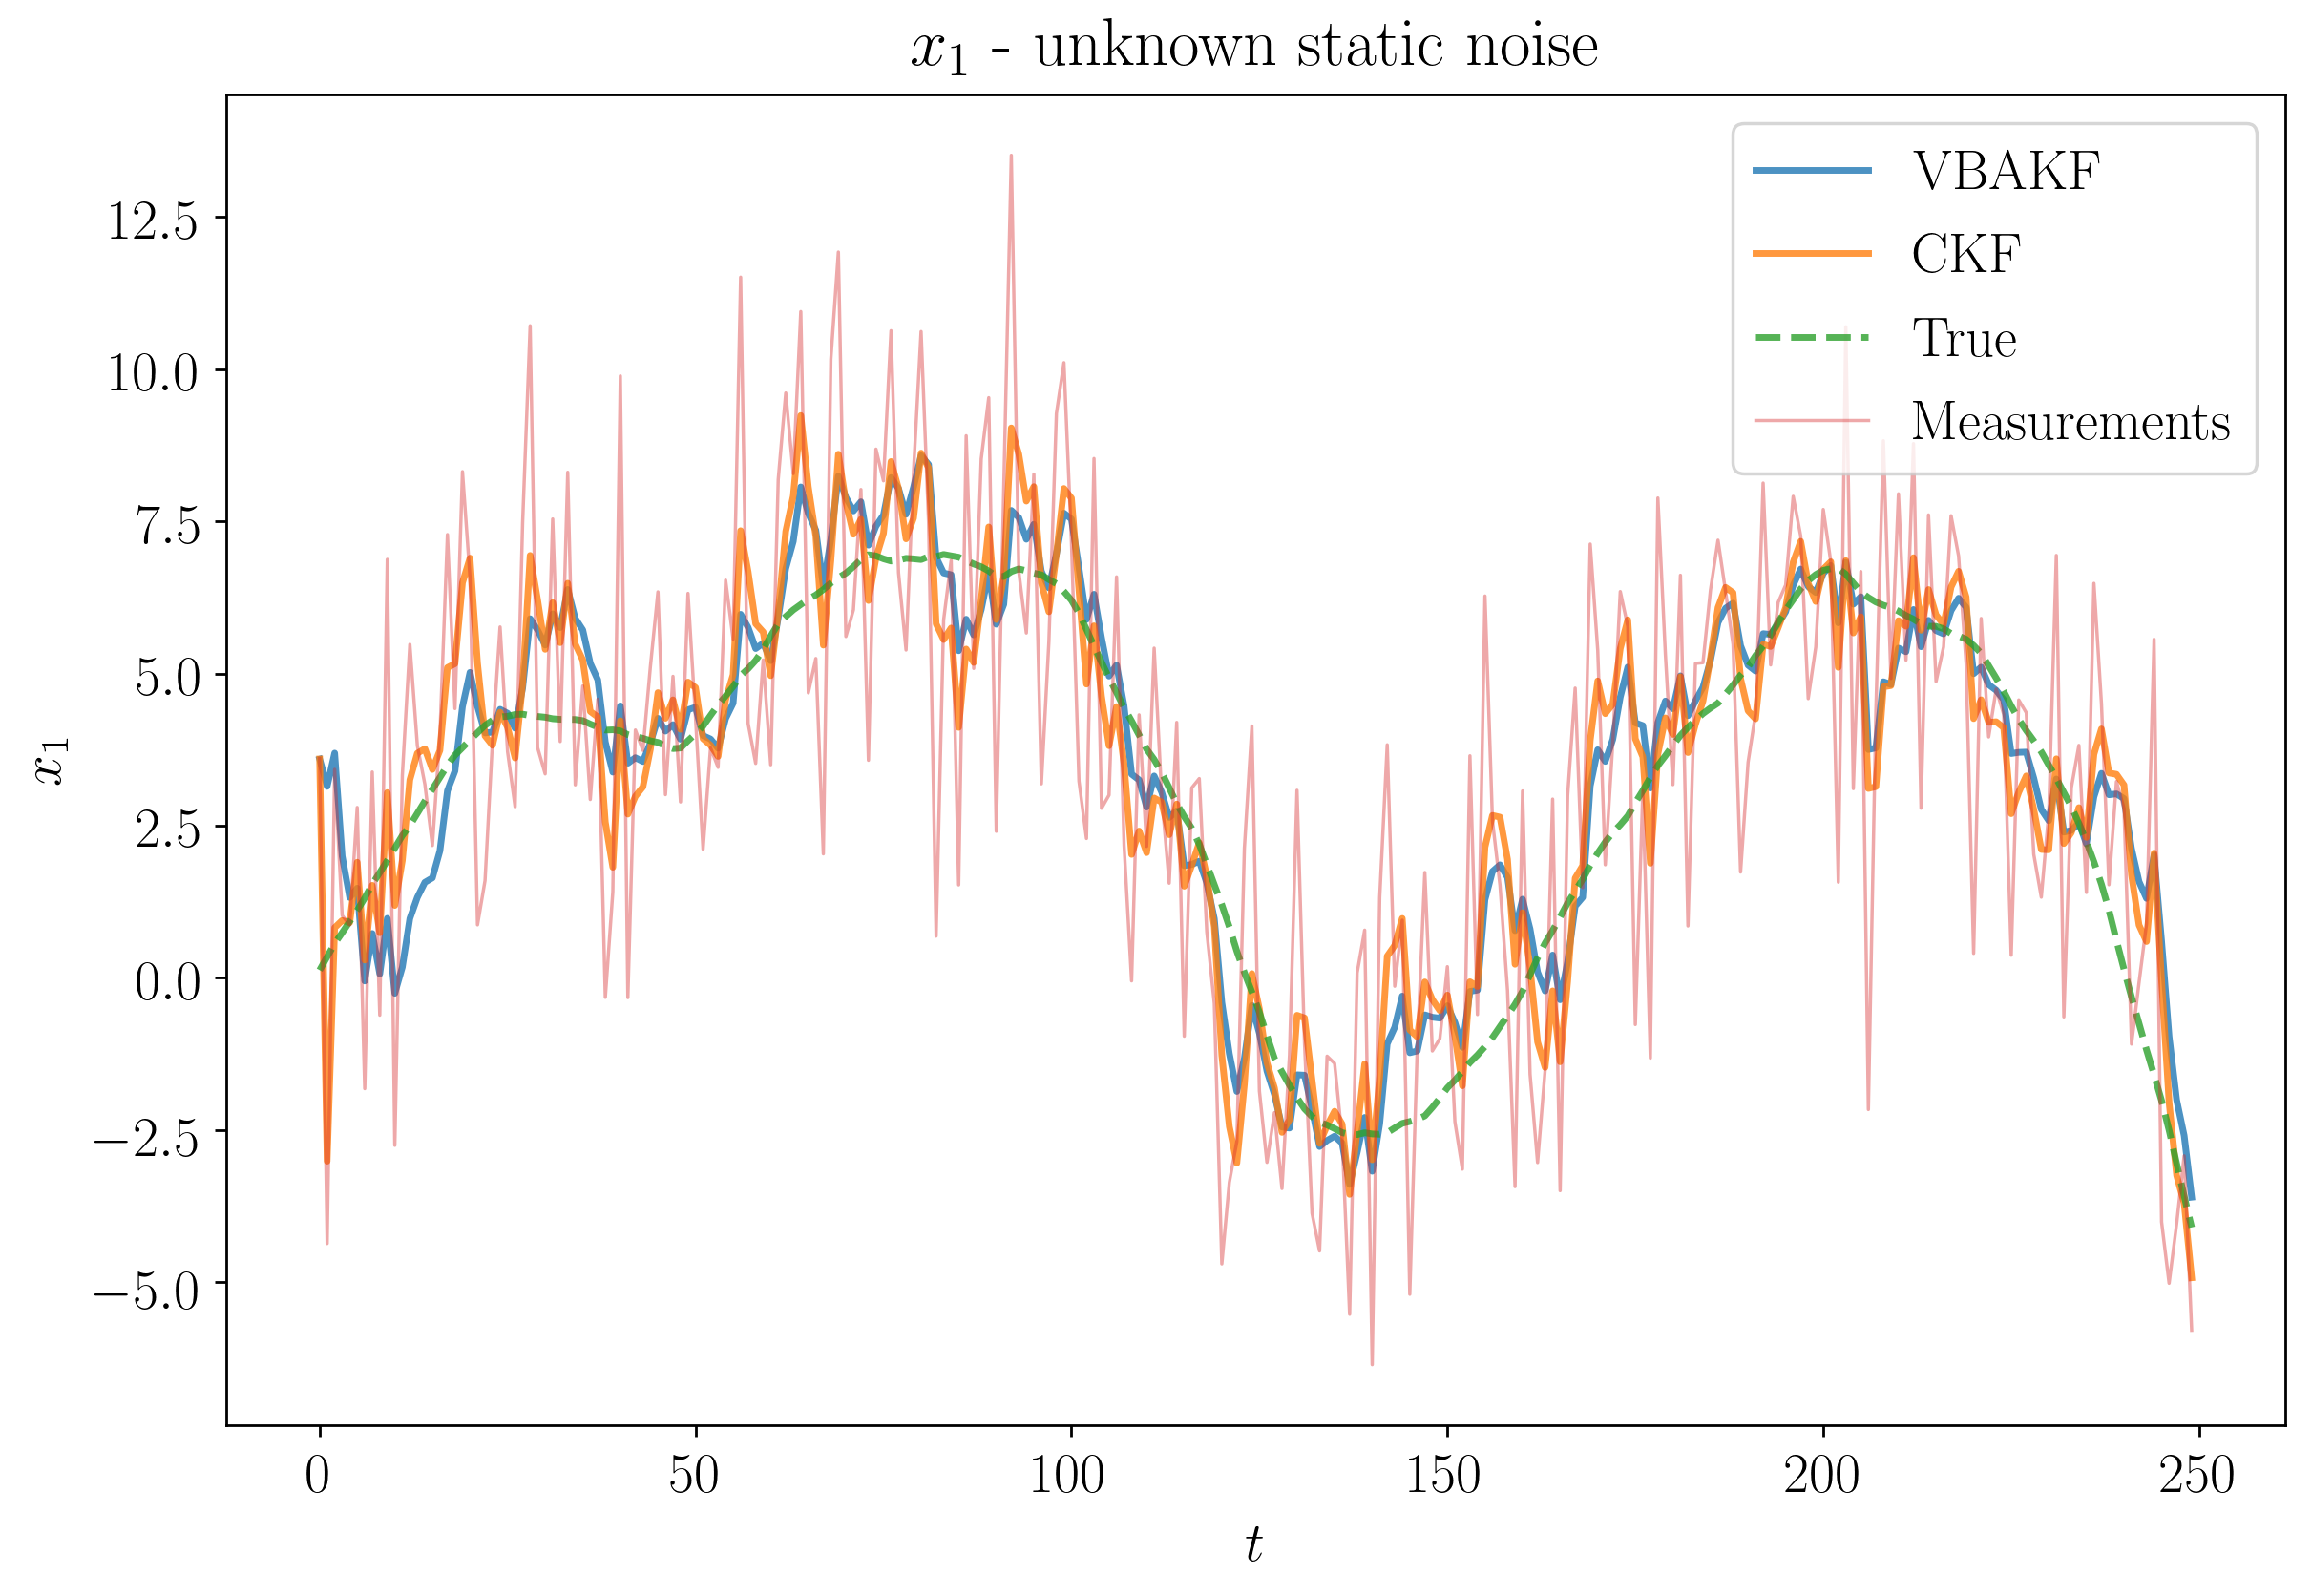

In [329]:
plot_comp(plt, 0, res_dv, res_kfc, true_traj, msrms, '$x_1$ - unknown static noise', '$x_1$')
savef('perf-static-unknown-x1.pdf')

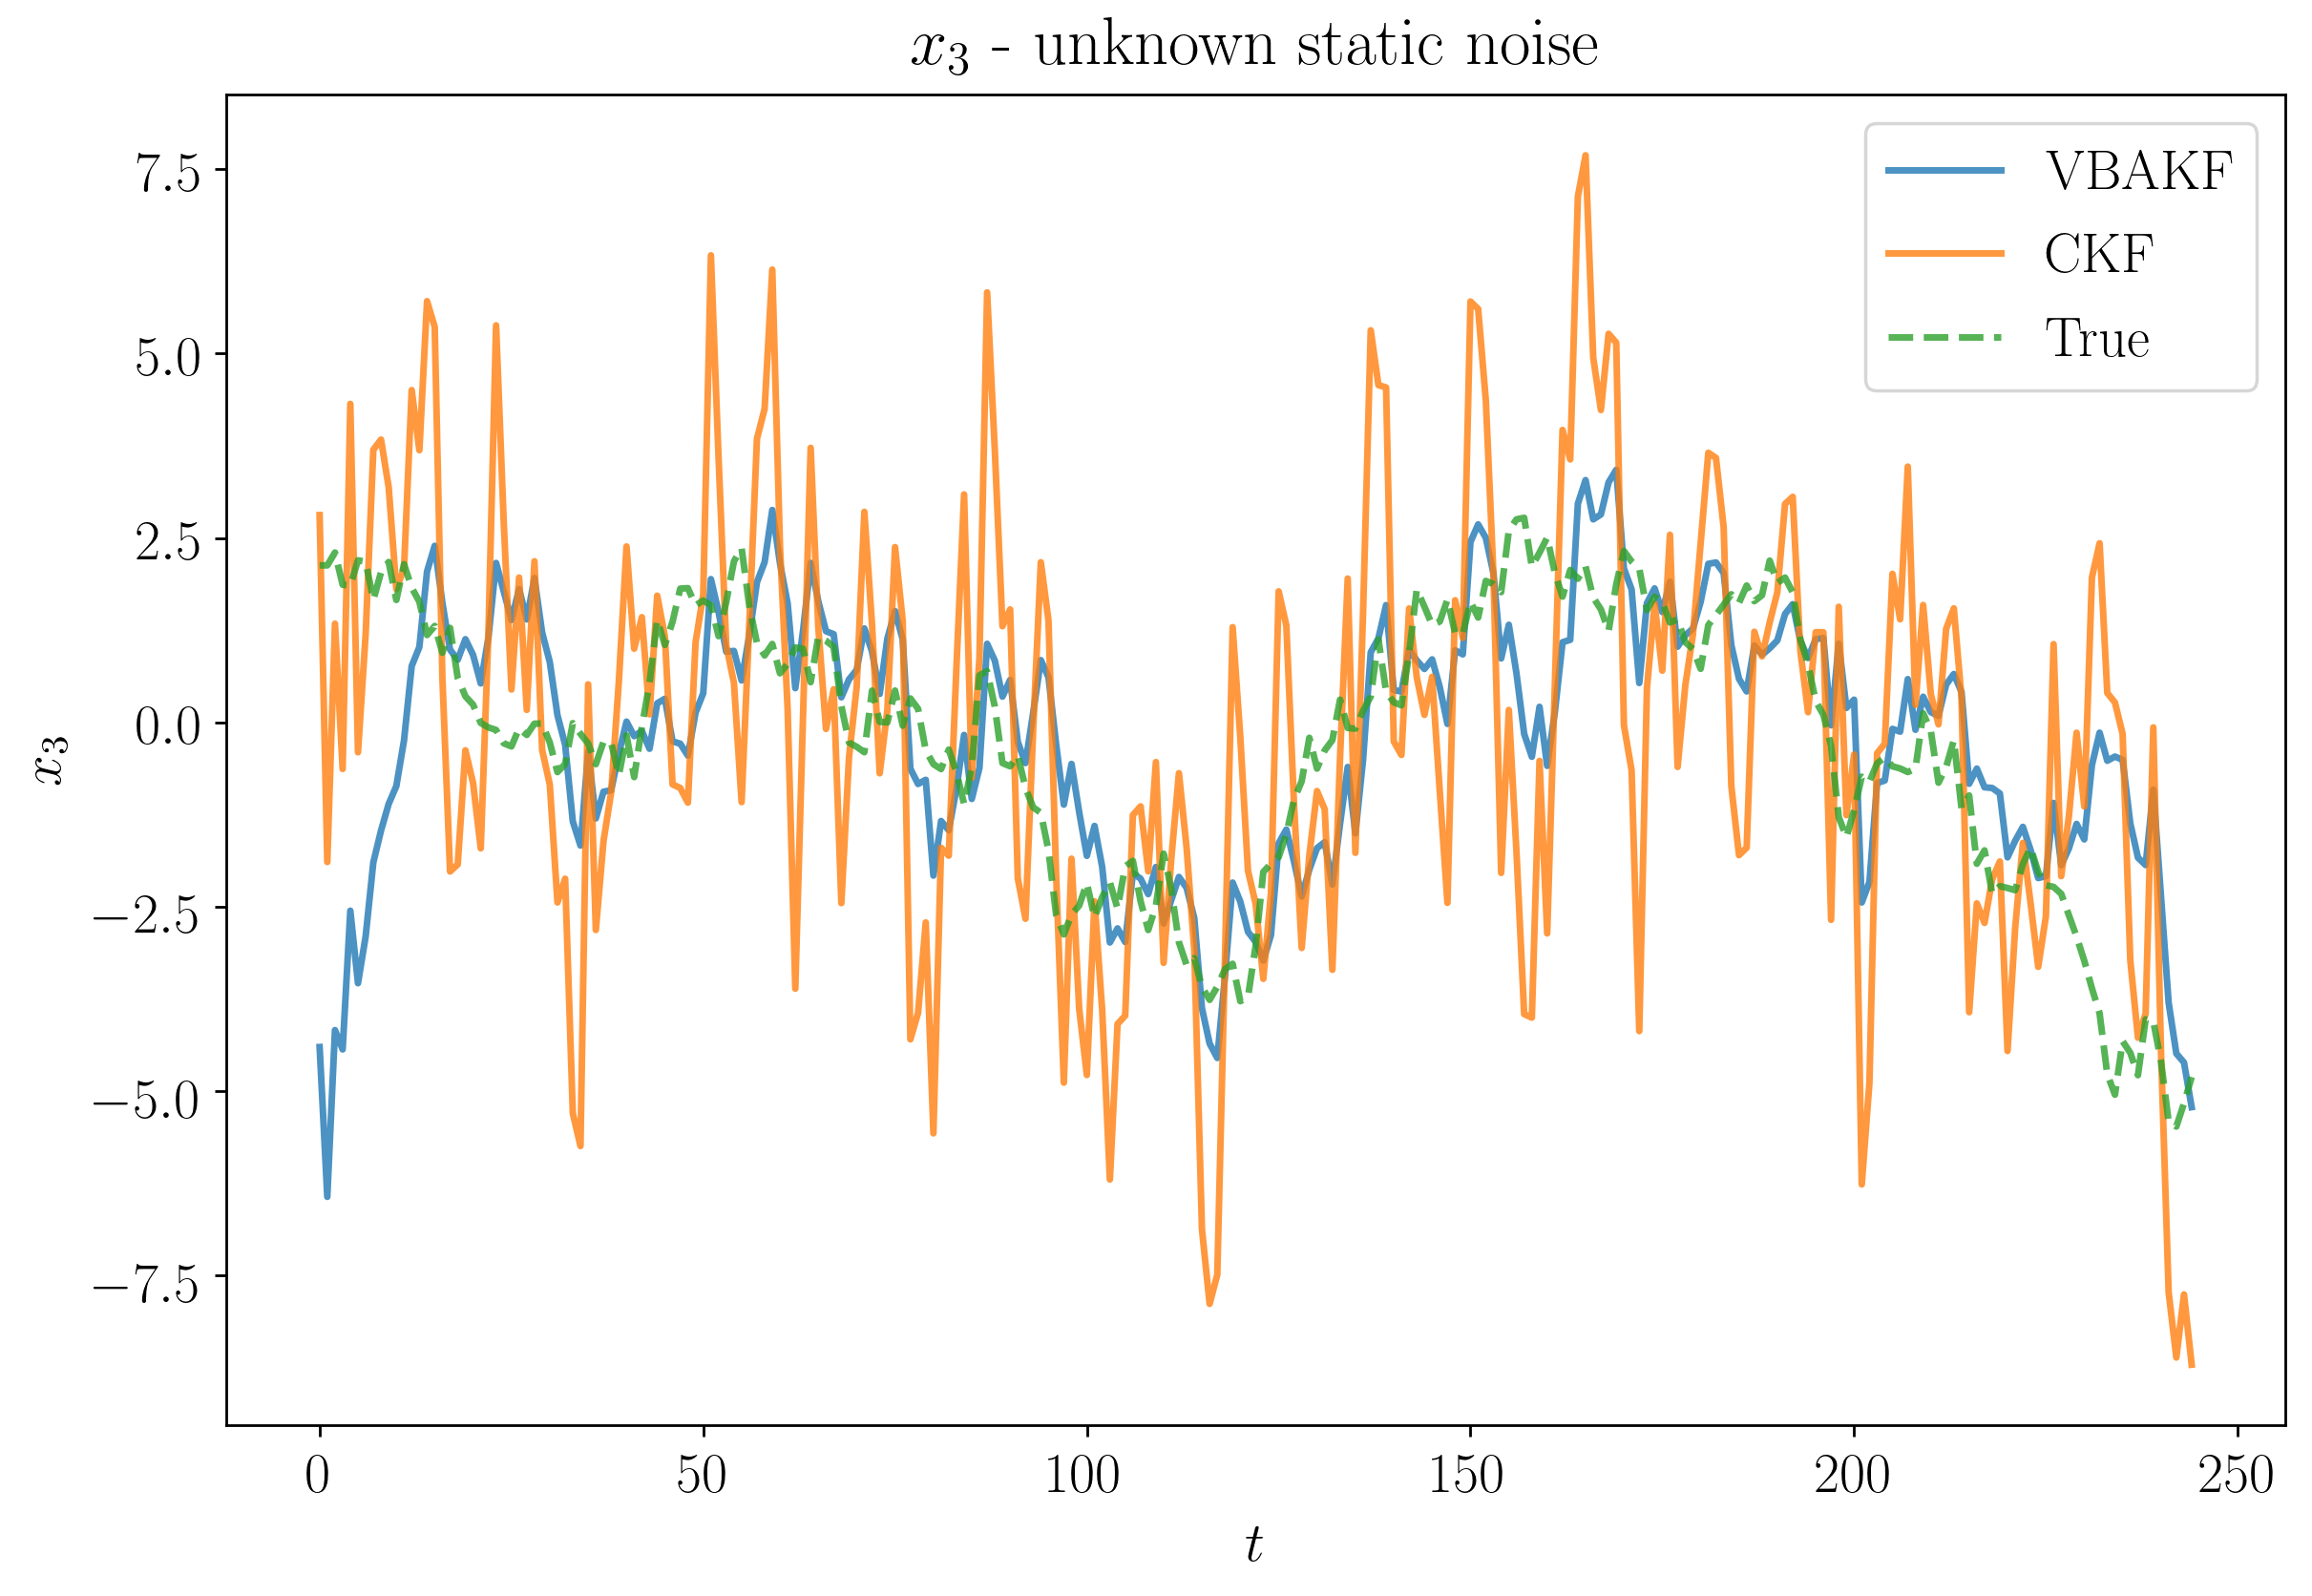

In [308]:
plot_comp(plt, 2, res_dv, res_kfc, true_traj, msrms=None, title='$x_3$ - unknown static noise', 
          ylabel='$x_3$', 
          start_pos=5)
savef('perf-static-unknown-x3.pdf')

# Sinus variable noise

In [349]:
suffix_text = "Unknown variable noise"
x1_text = "$x_1$"
x3_text = "$x_3$"
x1_sl = 0
x3_sl = 2

In [350]:
np.random.seed(SEED)
s = noise.sin_noise(N, 3)
n_sin = noise.static_noise(N, mod=8) * s

cov_init = abs(cov_traj) #+ np.cov(n_sin.T)
msrms = trj.Y + n_sin.T

res_dv, rms_dv, std_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.9)
res_kfc, rms_kfc, srd_kfc  = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv, std_dv)
print(rms_kfc, srd_kfc)

[0.599 0.648 1.026 0.965] [0.537 0.463 0.863 0.828]
[0.781 0.798 1.668 1.608] [0.716 0.662 1.359 1.307]


In [ ]:
import pandas as pd
import seaborn as sns

dt_sv = np.concatenate([rms_dv, rms_kfc])
dts_sv = np.concatenate([std_dv, srd_kfc])

df_sv = pd.DataFrame(
    {'RMSE': dt_sv,
     'STD': dts_sv,
     'Component': [f'$x_{i}$' for i in range(1, 5)]*2,
     'Algorithm': ['VBAKF']*4 + ['CKF']*4,
    })

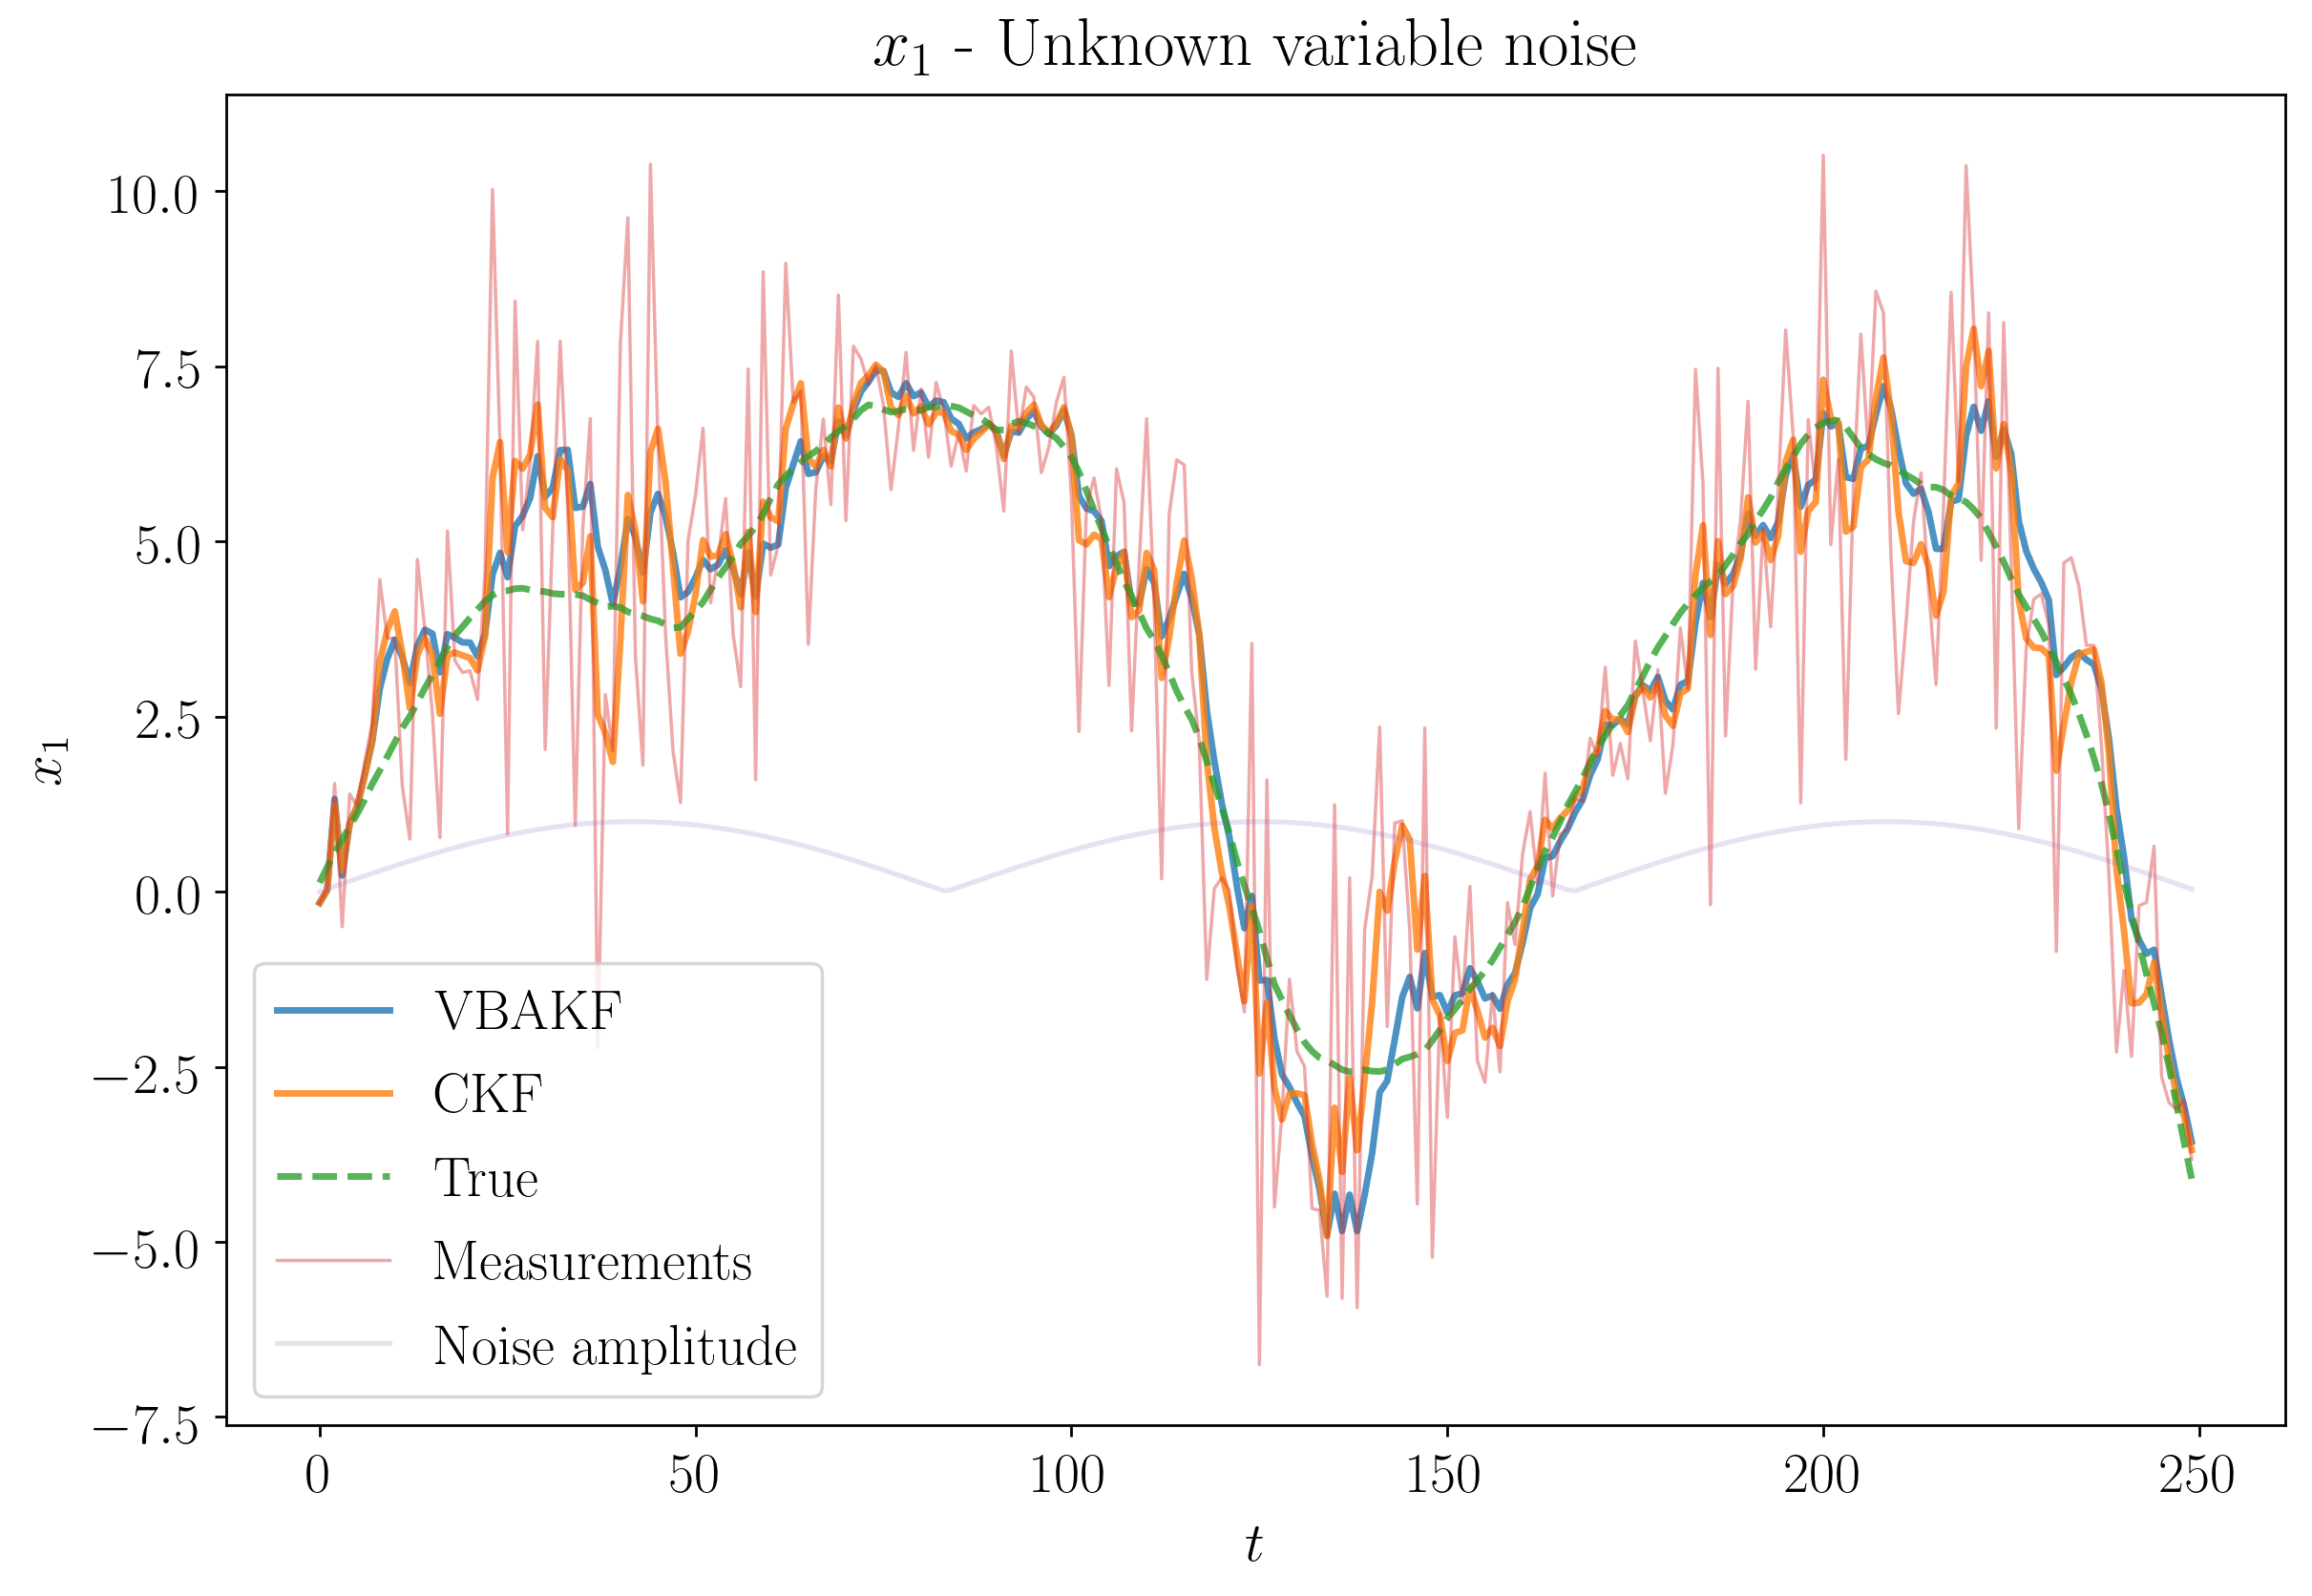

In [352]:
plot_comp(plt, x1_sl, res_dv, res_kfc, true_traj, msrms, x1_text + ' - ' + suffix_text, x1_text)
plt.plot(abs(s[:, 1]), label='Noise amplitude', alpha=0.2)
plt.legend()
savef('perf-static-sinus-x1.pdf')

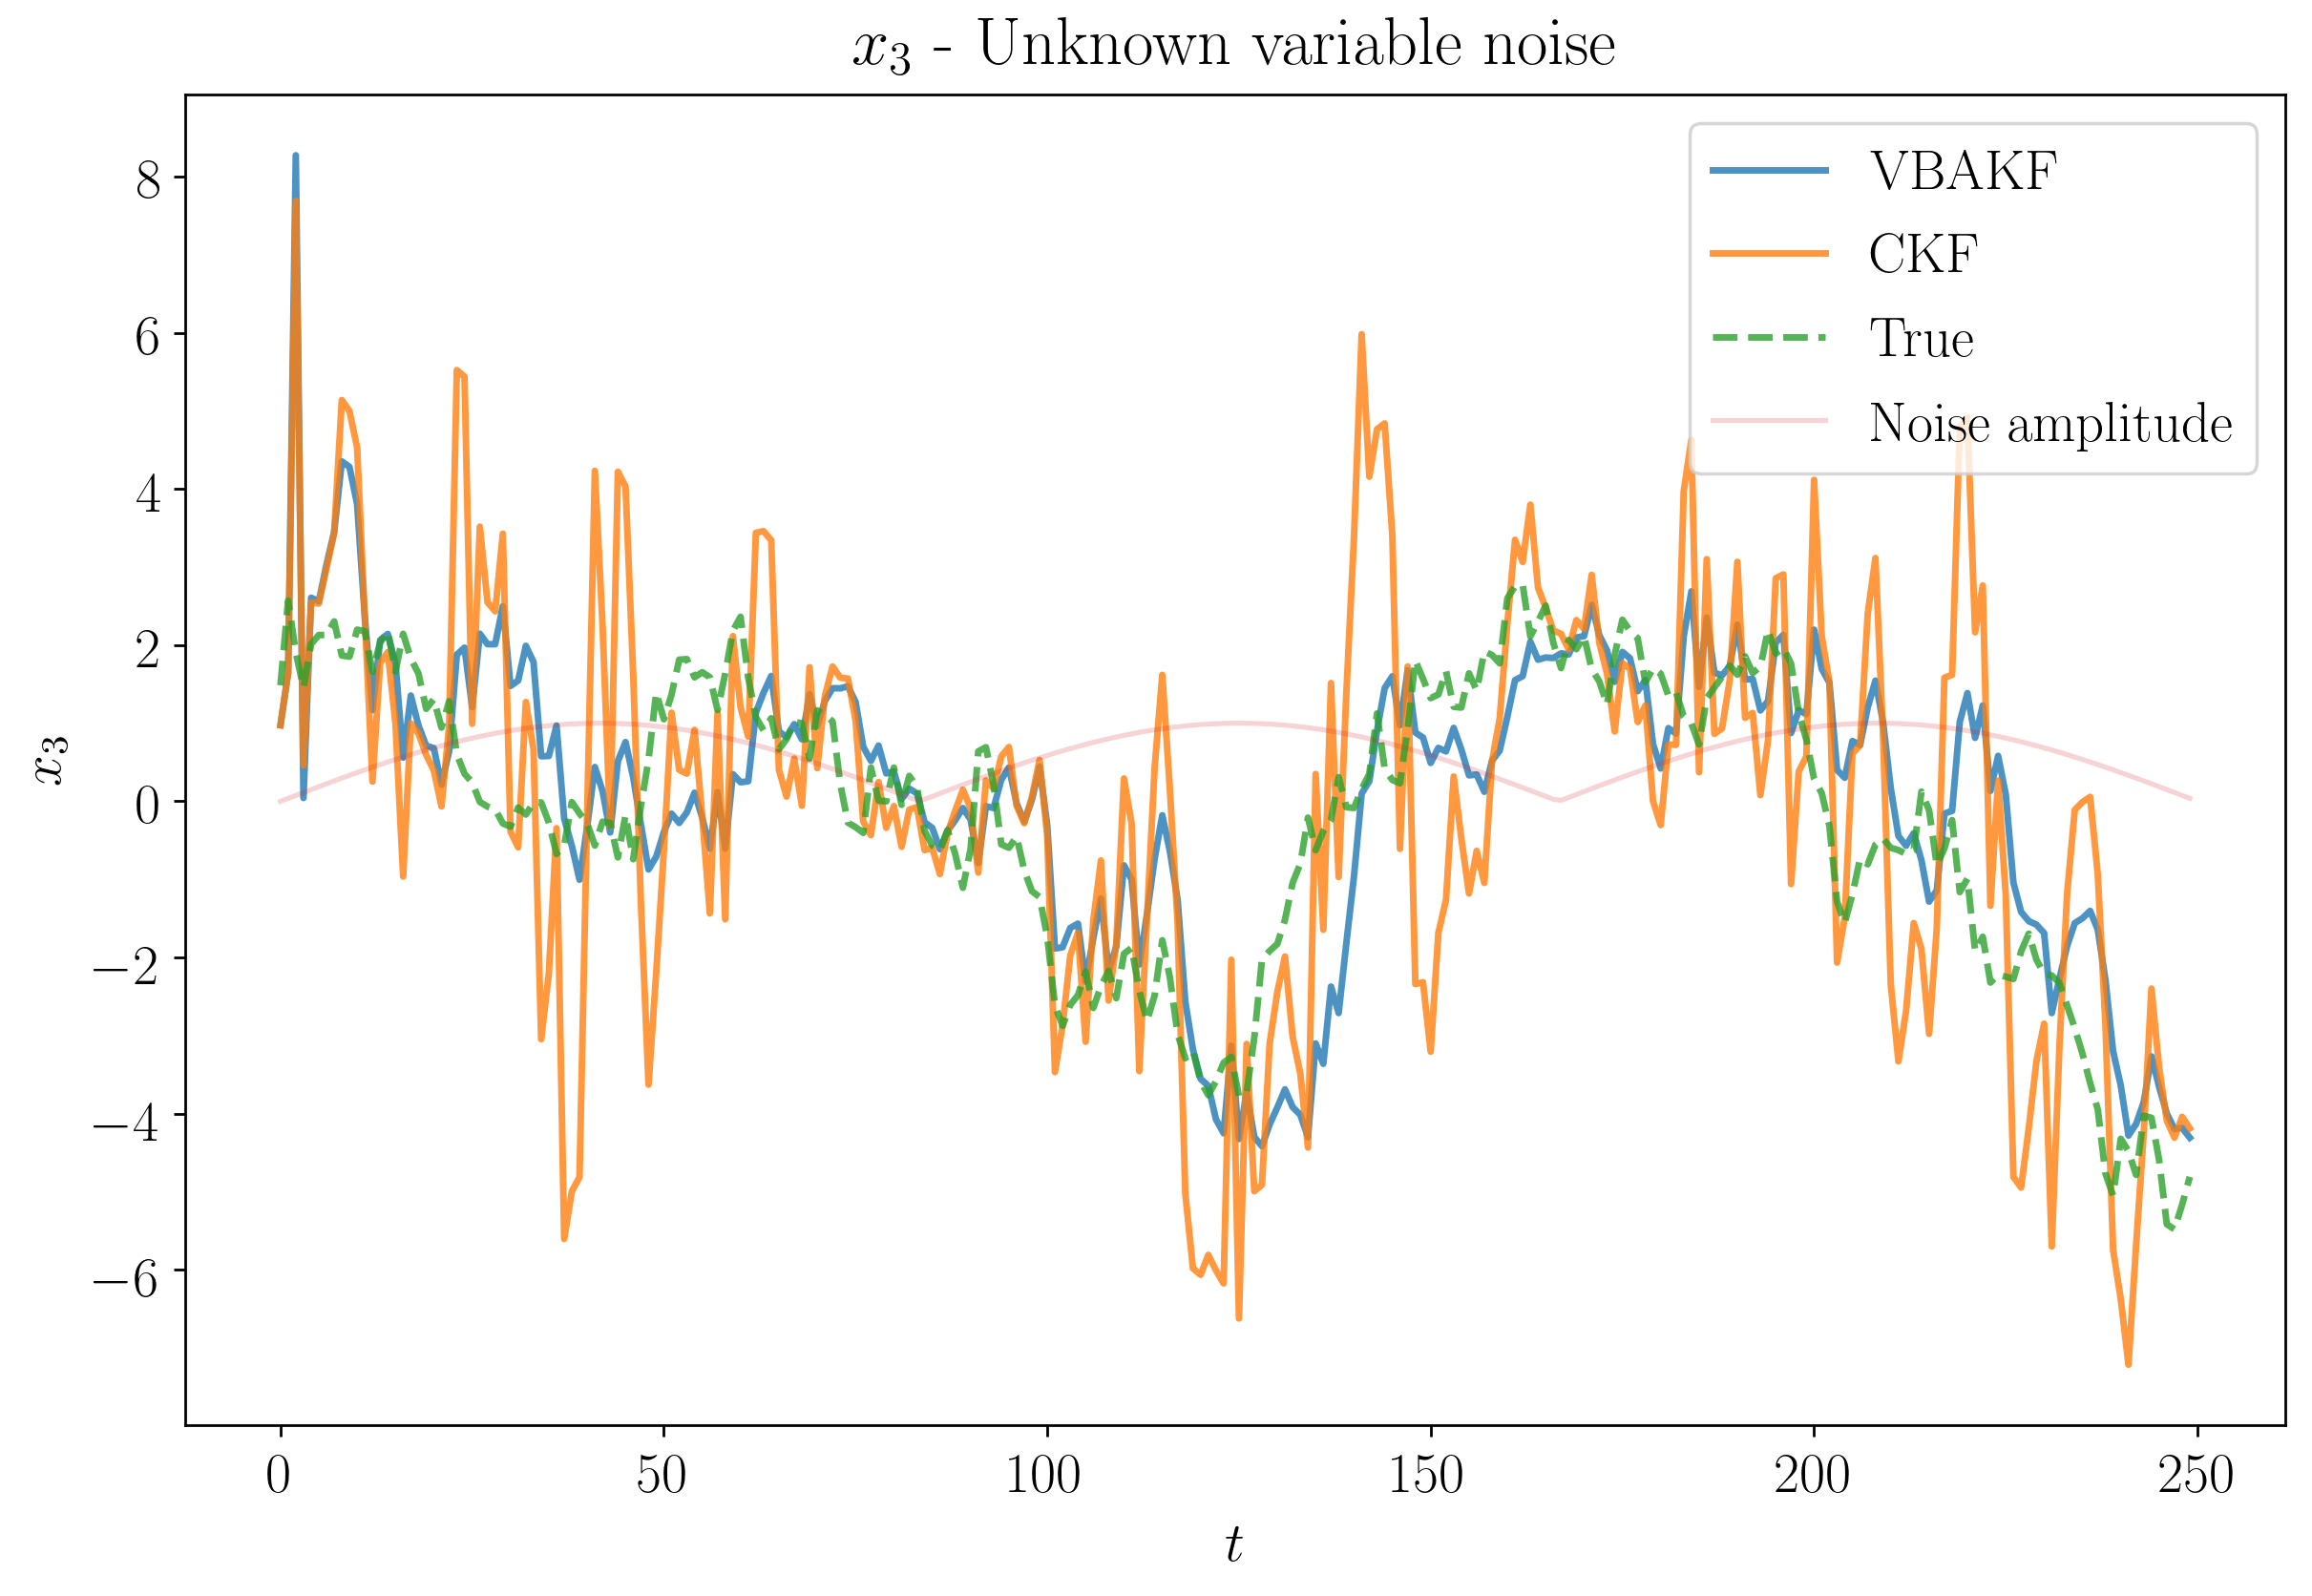

In [353]:
plot_comp(plt, x3_sl, res_dv, res_kfc, true_traj, msrms=None, title=x3_text + ' - ' + suffix_text, ylabel=x3_text)
plt.plot(abs(s[:, 1]), label='Noise amplitude', alpha=0.2)
plt.legend()
savef('perf-static-sinus-x3.pdf')

### Frobeniova norma - vzdálenost od původní matice

In [27]:
def rolling_window(a, shape):  # rolling window for 2D array
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

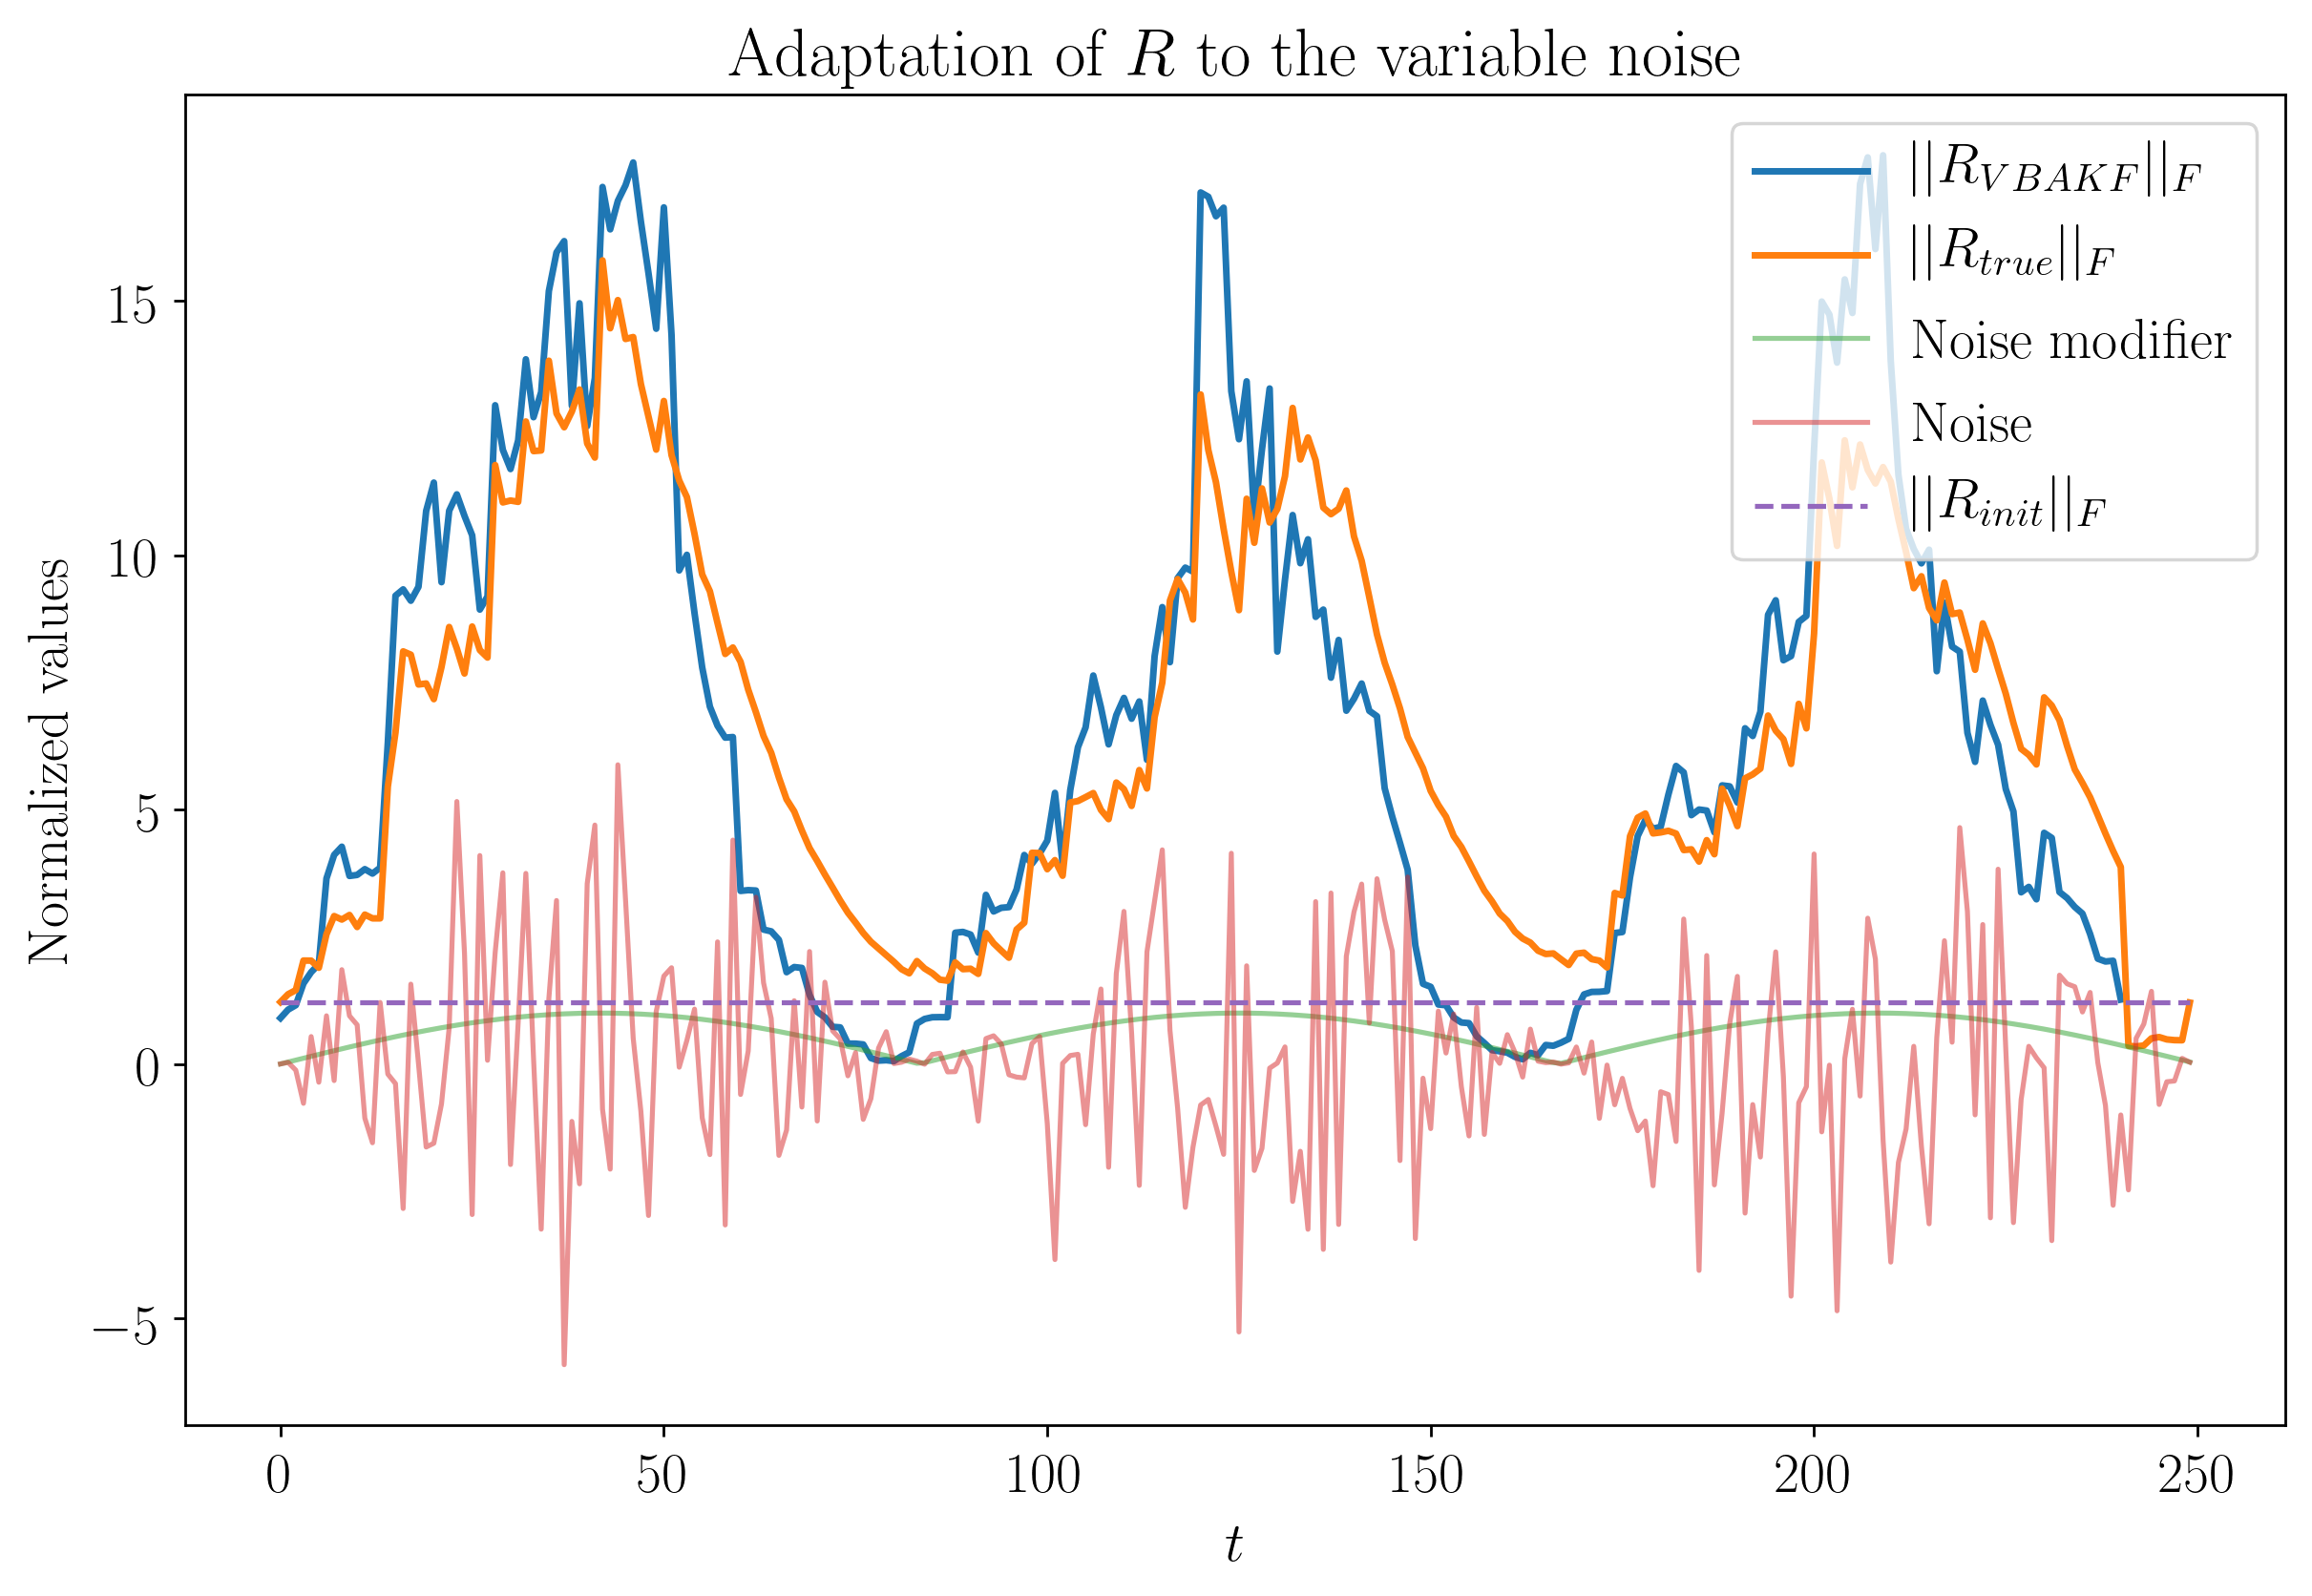

In [101]:
res_dv, rms_dv, std_dv, nd = daniels_variant(msrms, true_traj, cov_init, rho=0.9, debug=True)
rn = nd.norm_r()
true_rn = nd.norm_r() + np.linalg.norm(np.cov(n_sin.T))

rs = np.array([np.linalg.norm(np.cov(x[0].T)) for x in 
               rolling_window(n_sin, (10, 2))])
# have to roll it because of the rolling window shift
rn = np.roll(rn, -9)

plt.plot(rs, label=r'$||R_{VBAKF}||_F$', lw=2)
plt.plot(rn, label=r'$||R_{true}||_F$', lw=2)
plt.plot(abs(s[:, 0]), label='Noise modifier', alpha=0.5)
plt.plot(n_sin[:, 0], label='Noise', alpha=0.5)
plt.plot([rn[0]]*N, label=r'$||R_{init}||_F$', linestyle='--')
plt.xlabel('$t$')
plt.ylabel('Normalized values')
plt.title(r'Adaptation of $R$ to the variable noise')
plt.legend()
savef('adaptation-of-r.pdf')